# Práctica 2: Visualización de Tablas

Por Paula Vásquez-Henríquez (Cornershop, <pvasquezh@udd.cl>) y Eduardo Graells-Garrido (Barcelona Supercomputing Center, <eduardo.graells@bsc.es>).

#### Objetivo

La práctica anterior tuvo como objetivo describir el dataset de Encuesta Origen-Destino, y ver las posibilidades de visualizaciones que podían obtenerse a través de los datos. En esta práctica, seguiremos trabajando con ese dataset. Exploraremos preguntas cuyas respuestas se obtienen utilizando técnicas de visualización de tablas:

  1. ¿Cómo cambia la movilidad por grupos demográficos?
  2. ¿Cuáles son los patrones de propósitos de viaje por comuna y cómo se relacionan entre ellas?

#### Preámbulo y Carga de Datos

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from aves.data import eod
from aves.features.utils import normalize_rows, standardize_columns, normalize_columns
from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# esto configura la apariencia de los gráficos: tamaños de letra, bordes, colores base, etc.
sns.set(context='paper', font='Fira Code', style='ticks', palette='colorblind', font_scale=1.1)

Para la primera pregunta, necesitamos saber información de las personas que viajan, por lo que cargaremos la tabla de **personas**. Además, requerimos información de las distancias recorridas, la cual encontraremos en la tabla de **viajes**. También necesitamos saber donde se ubica el **hogar** de las personas, por lo que requerimos de esa tabla.

In [2]:
personas = eod.read_people()
personas.columns

Index(['Hogar', 'Persona', 'AnoNac', 'Sexo', 'Relacion', 'Viajes',
       'LicenciaConducir', 'PaseEscolar', 'AdultoMayor', 'Estudios', 'Curso',
       'Actividad', 'Ocupacion', 'ActividadEmpresa', 'JornadaTrabajo',
       'DondeEstudia', 'DirActividadCoordX', 'DirActividadCoordY',
       'DirEstudiosCoordX', 'DirEstudiosCoordY', 'NoViaja', 'TarjetaBip',
       'Tarjeta2Bip', 'MedioViajeRestricion', 'ConoceTransantiago',
       'NoUsaTransantiago', 'Discapacidad', 'TieneIngresos', 'Ingreso',
       'TramoIngreso', 'IngresoFinal', 'TramoIngresoFinal', 'IngresoImputado',
       'Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal',
       'Factor_LaboralEstival', 'Factor_FindesemanaEstival', 'FactorPersona'],
      dtype='object')

In [3]:
hogares = eod.read_homes()
hogares.columns

Index(['Hogar', 'Sector', 'Zona', 'Comuna', 'DirCoordX', 'DirCoordY', 'Fecha',
       'DiaAsig', 'TipoDia', 'Temporada', 'NumPer', 'NumVeh', 'NumBicAdulto',
       'NumBicNino', 'Propiedad', 'MontoDiv', 'ImputadoDiv', 'MontoArr',
       'ImputadoArr', 'IngresoHogar', 'FactorHogar'],
      dtype='object')

In [4]:
viajes = eod.read_trips()
viajes.columns

Index(['Hogar', 'Persona', 'Viaje', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
       'DistEuclidiana', 'DistManhattan', 'Imputada'],
      dtype='object')

In [5]:
tabla_completa = (viajes.merge(personas)).merge(hogares)

## 1. ¿Cómo cambia la movilidad por grupos demográficos?

Primero, debemos identificar cada uno de estos viajes y estas personas con los grupos de interés para nuestra pregunta. En este caso, nos interesan grupos como: *adulto mayor, estudiantes, mujeres y hombres*.
Para crear estos grupos, nos basaremos en distintas reglas a partir de la información de las tablas que unimos.

   * Para identificar a los adultos mayores, nos basaremos en el campo 'AdultoMayor'.
   * Para estudiantes, utilizaremos el campo 'PaseEscolar'.
   * Para identificar hombres y mujeres, utilizaremos el campo 'Sexo'.
   
Crearemos una función que nos permita identificar a cada grupo.

In [6]:
def label_grupo(row):
    if row['AdultoMayor'] == 1:
        return 'AdultoMayor'
    if row['PaseEscolar'] == 1:
        return 'Estudiante'
    if row['Sexo'] == 'Mujer':
        return 'Mujer'
    return 'Hombre'

In [7]:
personas['GrupoDem'] = personas.apply(lambda row: label_grupo(row), axis=1)

In [8]:
personas['GrupoDem'].value_counts()

Mujer          25755
Hombre         22798
Estudiante      9731
AdultoMayor     1770
Name: GrupoDem, dtype: int64

Hagamos una revisión rápida de la distribución de edad de estos grupos, para saber si son coherentes con lo que esperamos de ellos. Usemos `seaborn` para ello:

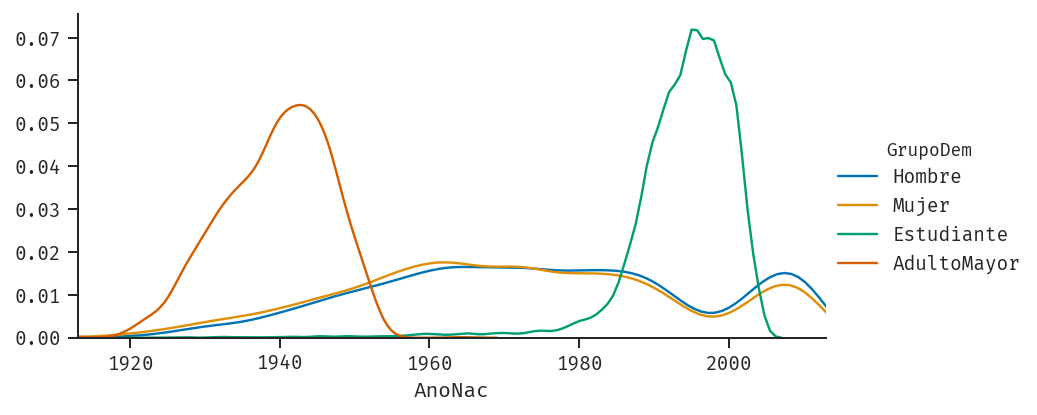

In [9]:
(sns.FacetGrid(data=personas, hue='GrupoDem', legend_out=True, aspect=2)
 .map(sns.kdeplot, 'AnoNac')
 .set(xlim=[1913, 2013])
 .add_legend()
)

En relación a la codificación visual de este gráfico, le hemos dicho a `kdeplot` que queremos que calcule datos derivados (la distribución) del atributo cuantitativo `AnoNac`. A `FacetGrid` le hemos dicho que el canal `hue` codificará los atributos categóricos de la variable `GrupoDem`.

Luego, queremos saber cuantos viajes están asociados a cada persona dentro de nuestro dataset.

In [10]:
n_viajes_persona = tabla_completa['Persona'].value_counts(sort=False).rename('n_viajes')
n_viajes_persona

23855104    2
16132101    5
10500103    2
16558101    2
21934102    4
           ..
18774001    2
19290101    4
24922103    2
25438203    2
18223102    2
Name: n_viajes, Length: 46266, dtype: int64

Ahora cruzaremos este conteo de viajes con los datos de grupo demográfico. Antes de hacerlo, consideraremos que en los datos **hay personas que no hicieron viajes**: recuerden que la encuesta se aplica a un hogar completo. Por tanto no basta ver la tabla de viajes para contar los viajes de cada persona. Eso explica el por qué hacemos el `join` de esta manera:

In [11]:
n_viajes_persona_meta = (personas[['GrupoDem', 'Persona']]
                         .join(n_viajes_persona, on='Persona', how='left')
                         .fillna(0)
)

Quienes no estén en el conteo de viajes pero sí en la tabla de personas, tendrán un valor nulo (eso hace el parámetro `how='left'`), que hemos llenado con un `0` puesto que tiene sentido decir que un valor nulo implica cero viajes.

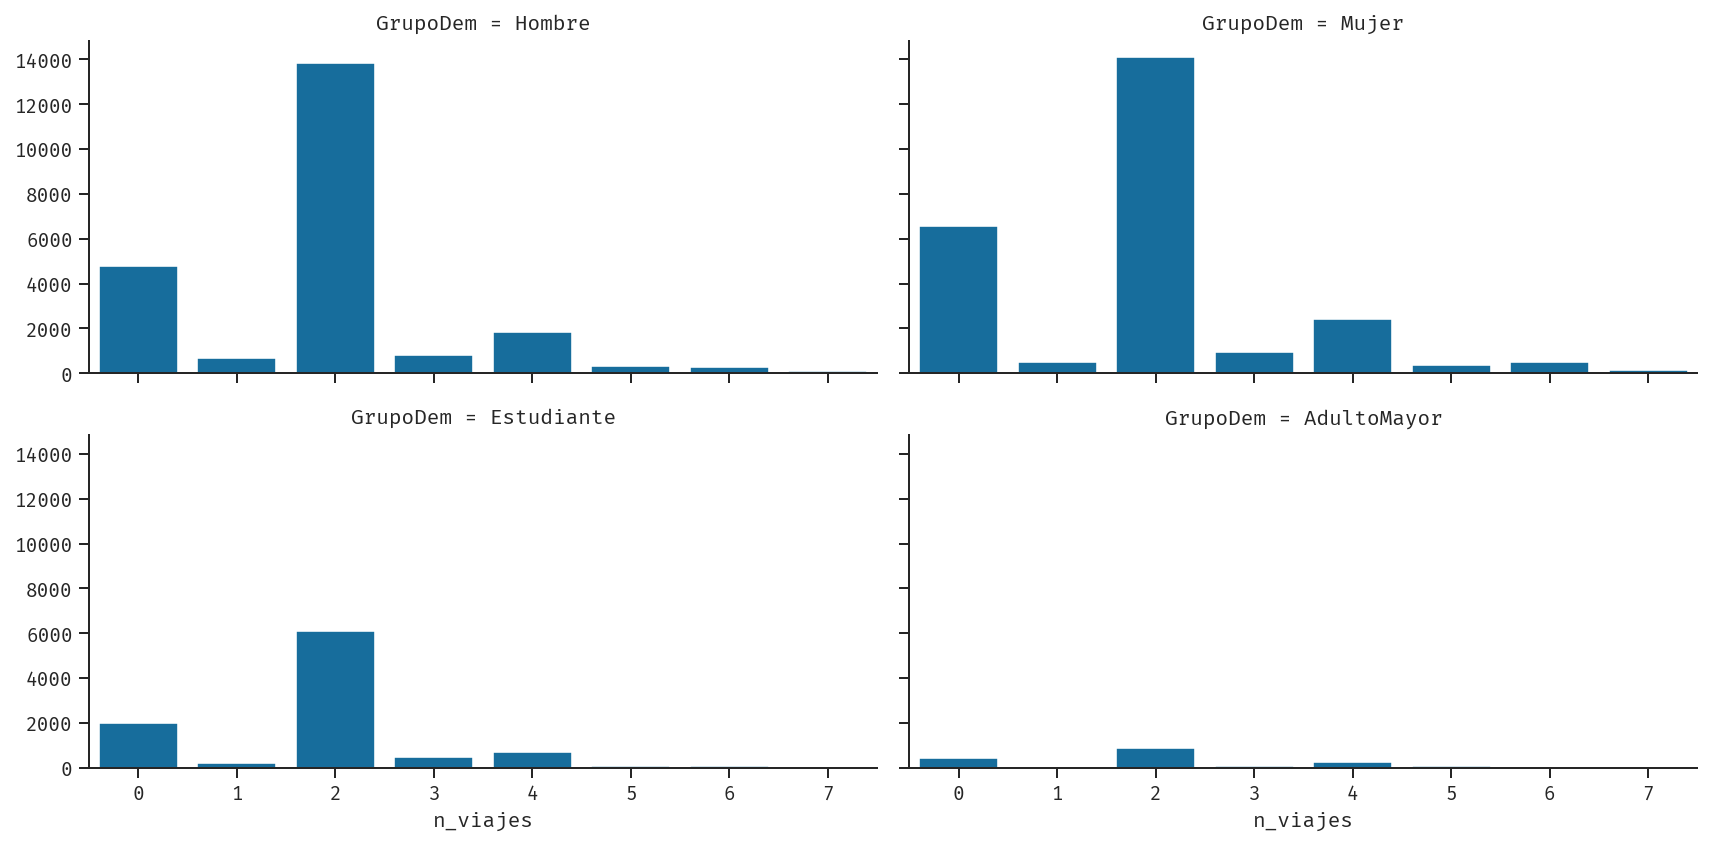

In [12]:
(sns.FacetGrid(data=n_viajes_persona_meta, col='GrupoDem', col_wrap=2, aspect=2)
 .map(sns.countplot, 'n_viajes', order=range(0, 8))
)

Podemos ver que la distribucion de la cantidad de viajes entre hombres y mujeres parece ser similar. Además, la moda de todos los grupos son dos viajes. Veamos el mismo gráfico desde otra perspectiva, cambiando la `llave` de codificación:

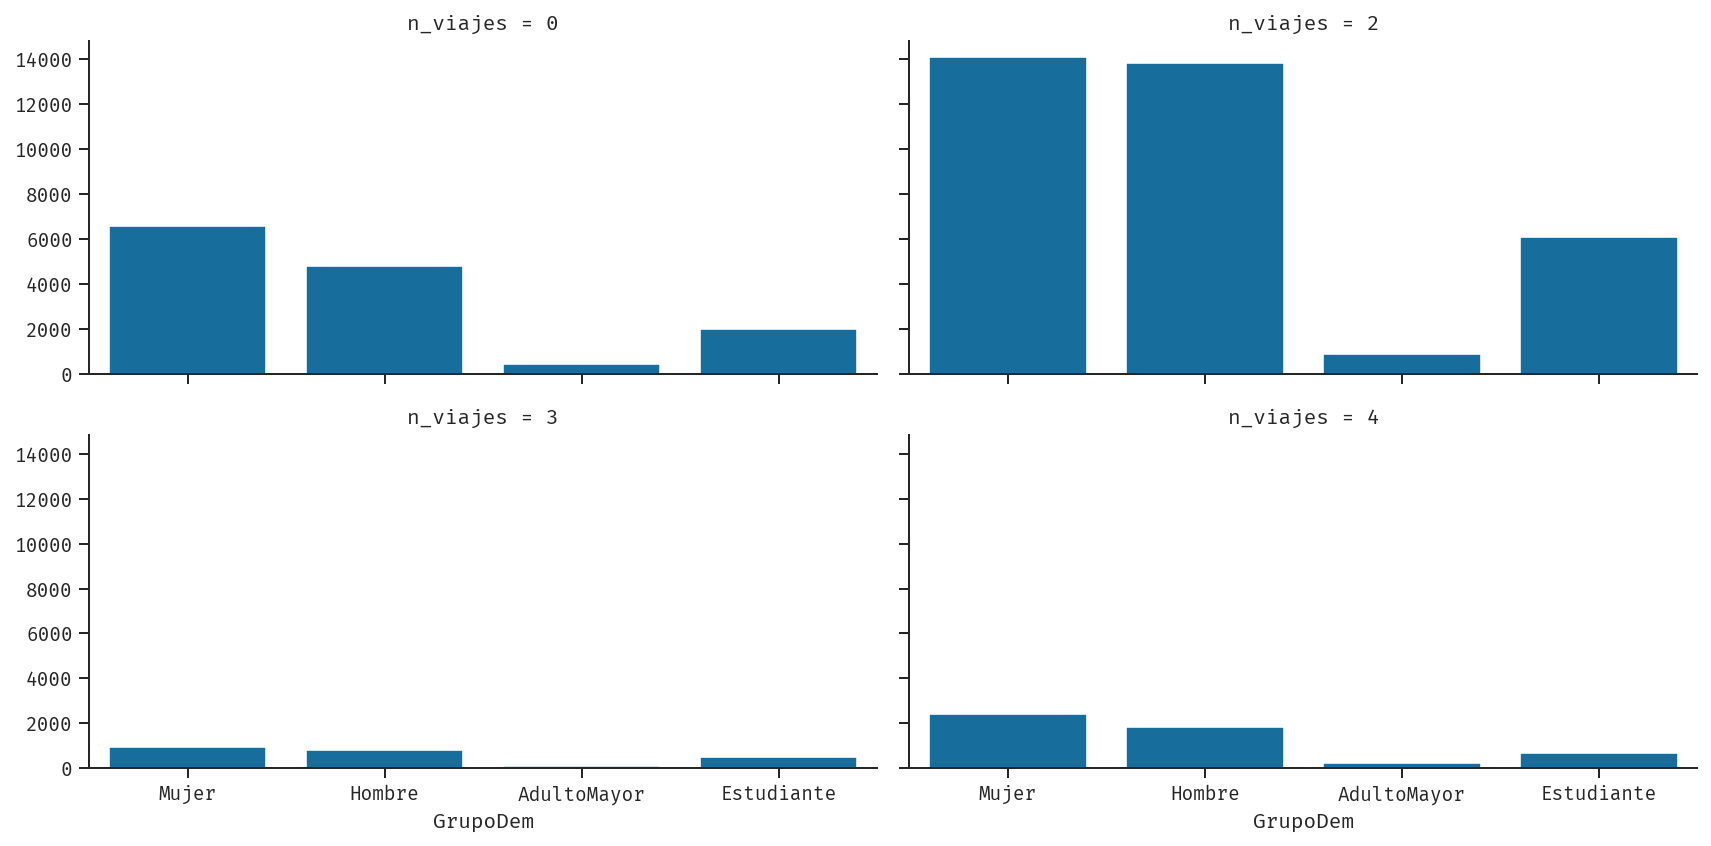

In [13]:
(sns.FacetGrid(data=n_viajes_persona_meta, col='n_viajes', col_wrap=2, col_order=(0, 2, 3, 4), aspect=2)
 .map(sns.countplot, 'GrupoDem', orient='horizontal', order=['Mujer', 'Hombre', 'AdultoMayor', 'Estudiante'])
)

Hay diferencias que esperábamos (estudiantes y adultos mayores), pero podríamos preguntarnos **si la distribución del numero de viajes entre hombres y mujeres es la misma a lo largo de todas sus vidas**. Para poder visualizar esto, calcularemos la cantidad de viajes que realizan hombres y mujeres de acuerdo a la edad, para comprobar si existen diferencias.

In [14]:
n_viajes_age_gender = (personas[['Persona', 'AnoNac', 'Sexo']]
                       .join(n_viajes_persona, how='left', on='Persona')
                       .fillna(0)
                       .assign(edad=lambda x: 2013 - x.AnoNac))
n_viajes_age_gender.head()

,Persona,AnoNac,Sexo,n_viajes,edad
0,10001001,1958,Hombre,2.0,55
1,10001002,1956,Mujer,5.0,57
2,10001003,1982,Mujer,0.0,31
3,10002001,1954,Hombre,4.0,59
4,10002002,1961,Mujer,2.0,52


Veamos a los usuarios que **NO realizan viajes**. ¿Existirá alguna tendencia relacionada al género?

In [15]:
n_viajes_age_gender[n_viajes_age_gender['n_viajes'] < 1].groupby('Sexo').size()

Sexo
Hombre    5955
Mujer     7833
dtype: int64

In [16]:
users_sin_viajes = (n_viajes_age_gender[n_viajes_age_gender['n_viajes'] < 1]
                    .groupby(['edad', 'Sexo'])
                    .size()
                    .rename('n_personas')
                    .to_frame()
                    .reset_index())
users_sin_viajes

,edad,Sexo,n_personas
0,0,Hombre,32
1,0,Mujer,32
2,1,Hombre,189
3,1,Mujer,167
4,2,Hombre,179
...,...,...,...
201,101,Hombre,1
202,101,Mujer,2
203,102,Mujer,1
204,103,Mujer,1


Tenemos una tabla con la cantidad de hombres y mujeres que _no_ salen del hogar. La llave puede ser es el valor cuantitativo `edad`, un atributo cuantitativo es `n_personas`, y un atributo categórico es `Sexo`. Esto podemos codificarlo en un `lineplot` que muestre dos líneas, una por cada sexo:

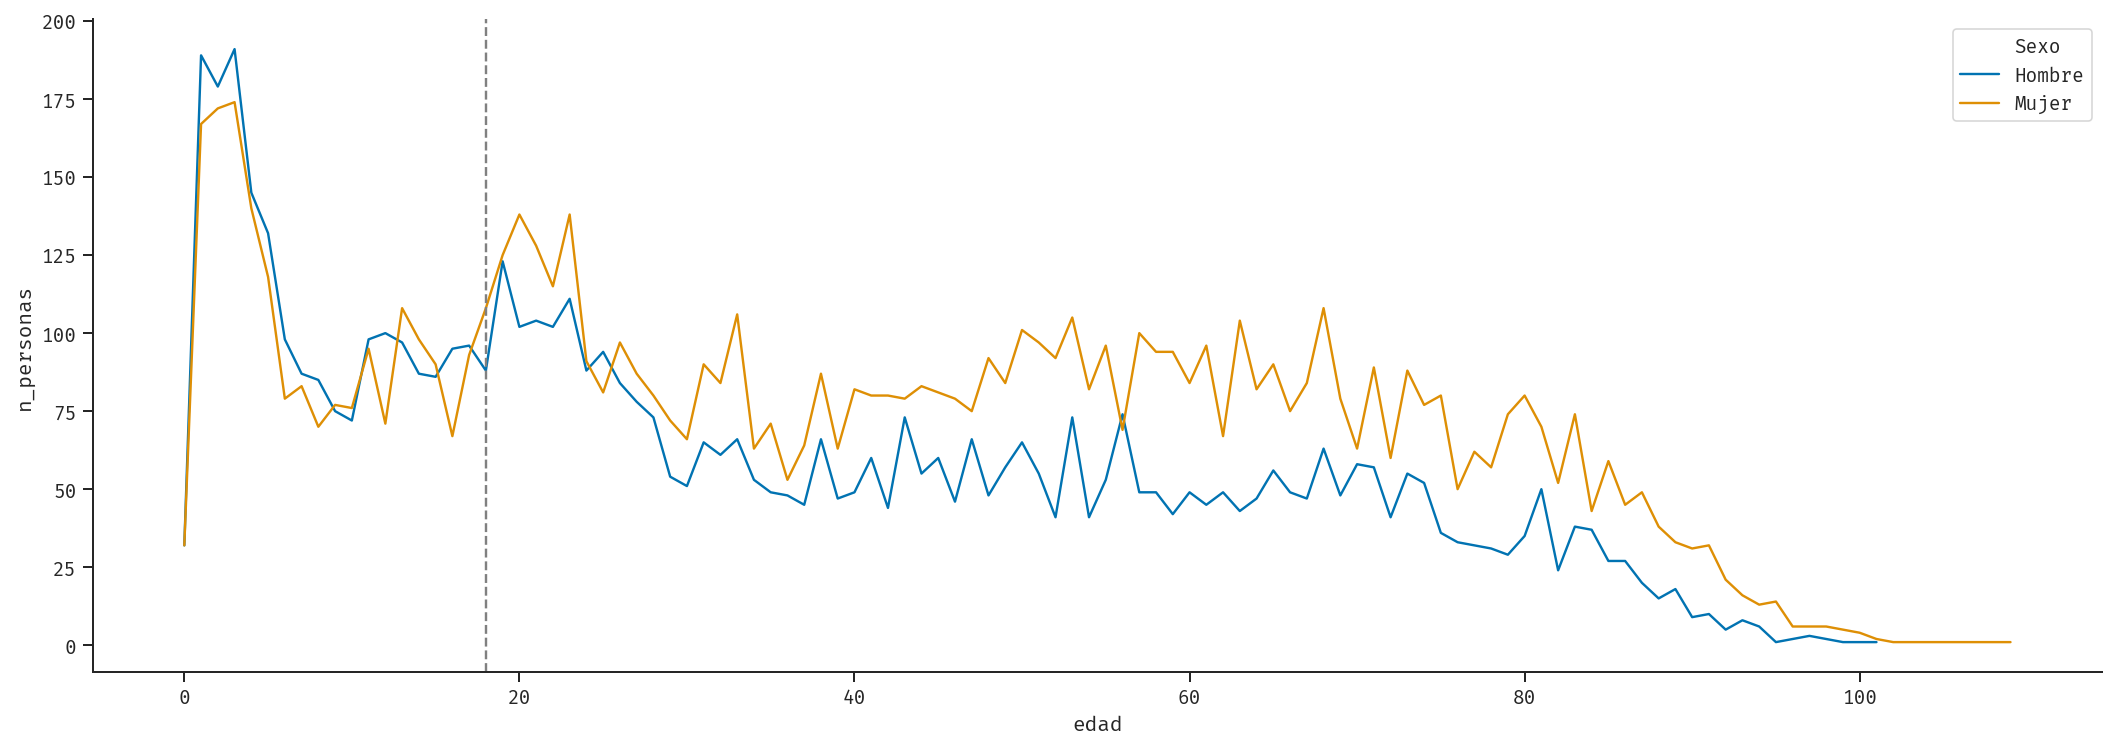

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.lineplot(x='edad', y='n_personas', hue='Sexo', data=users_sin_viajes, ax=ax)
ax.axvline(x=18, linestyle='--', color='grey')
sns.despine(ax=ax)

Podemos ver que a partir de cierta edad, las mujeres tienen mayor tendencia a no realizar viajes en comparación a los hombres.

Ahora, revisemos como cambia el numero de viajes realizados con respecto a la edad para el total de las personas:

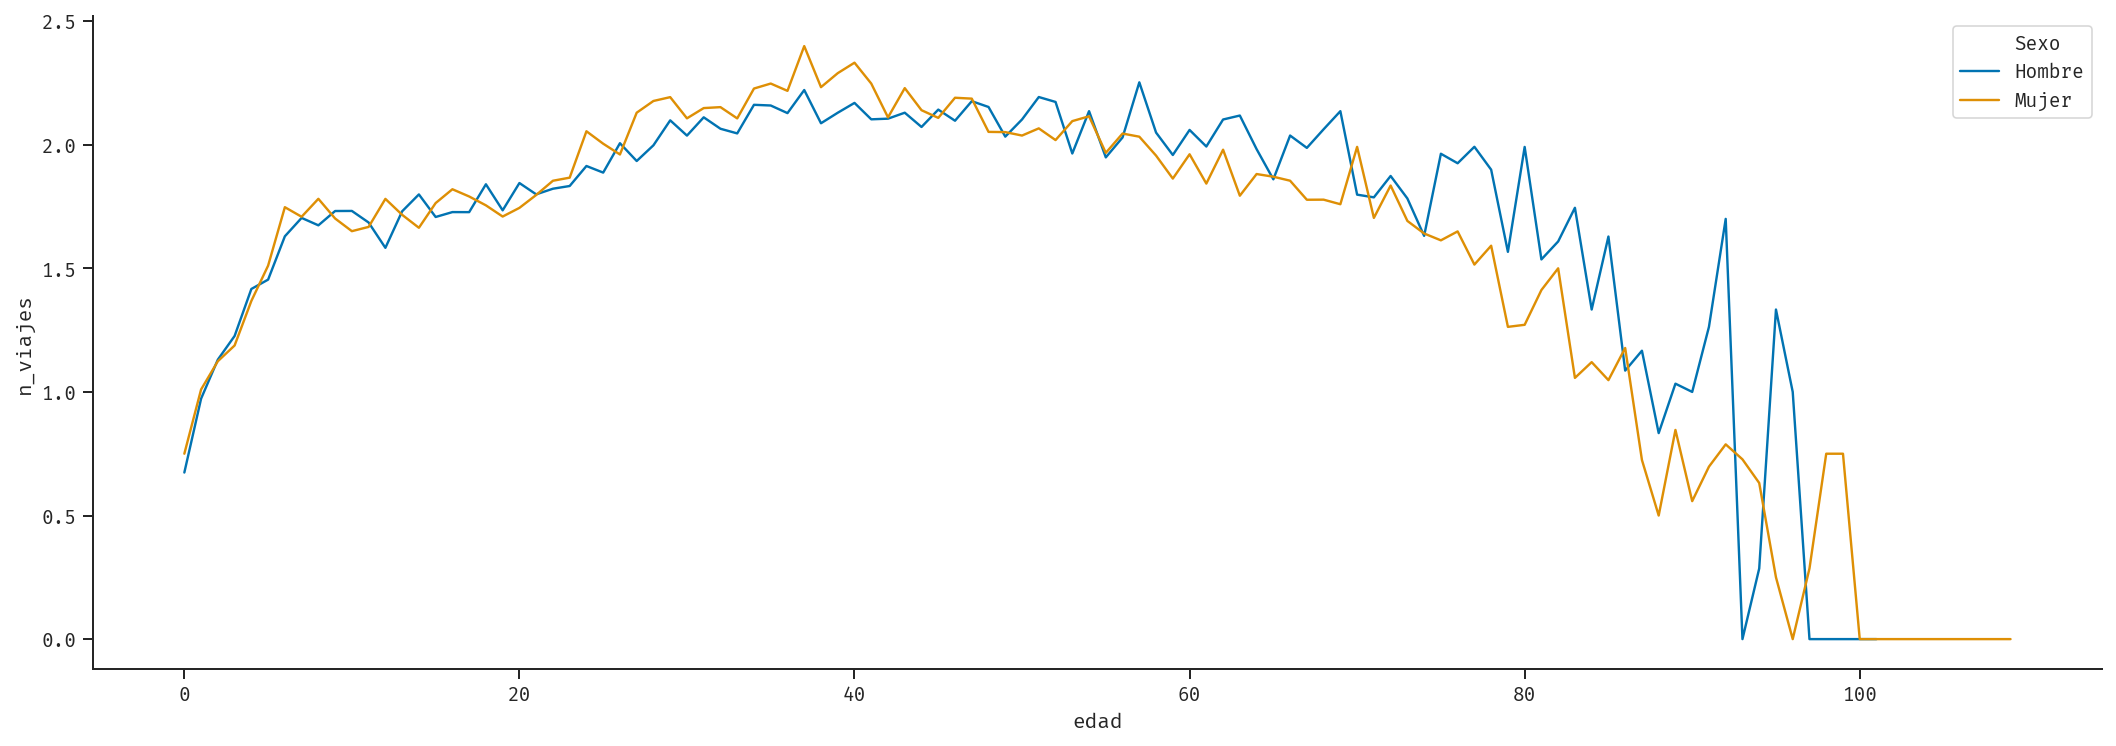

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.lineplot(x='edad', y='n_viajes', hue='Sexo', data=n_viajes_age_gender, ci=None, ax=ax)
sns.despine(ax=ax)

Considerando el total no parece haber grandes diferencias. Veamos qué sucede con la gente que sí realiza viajes:

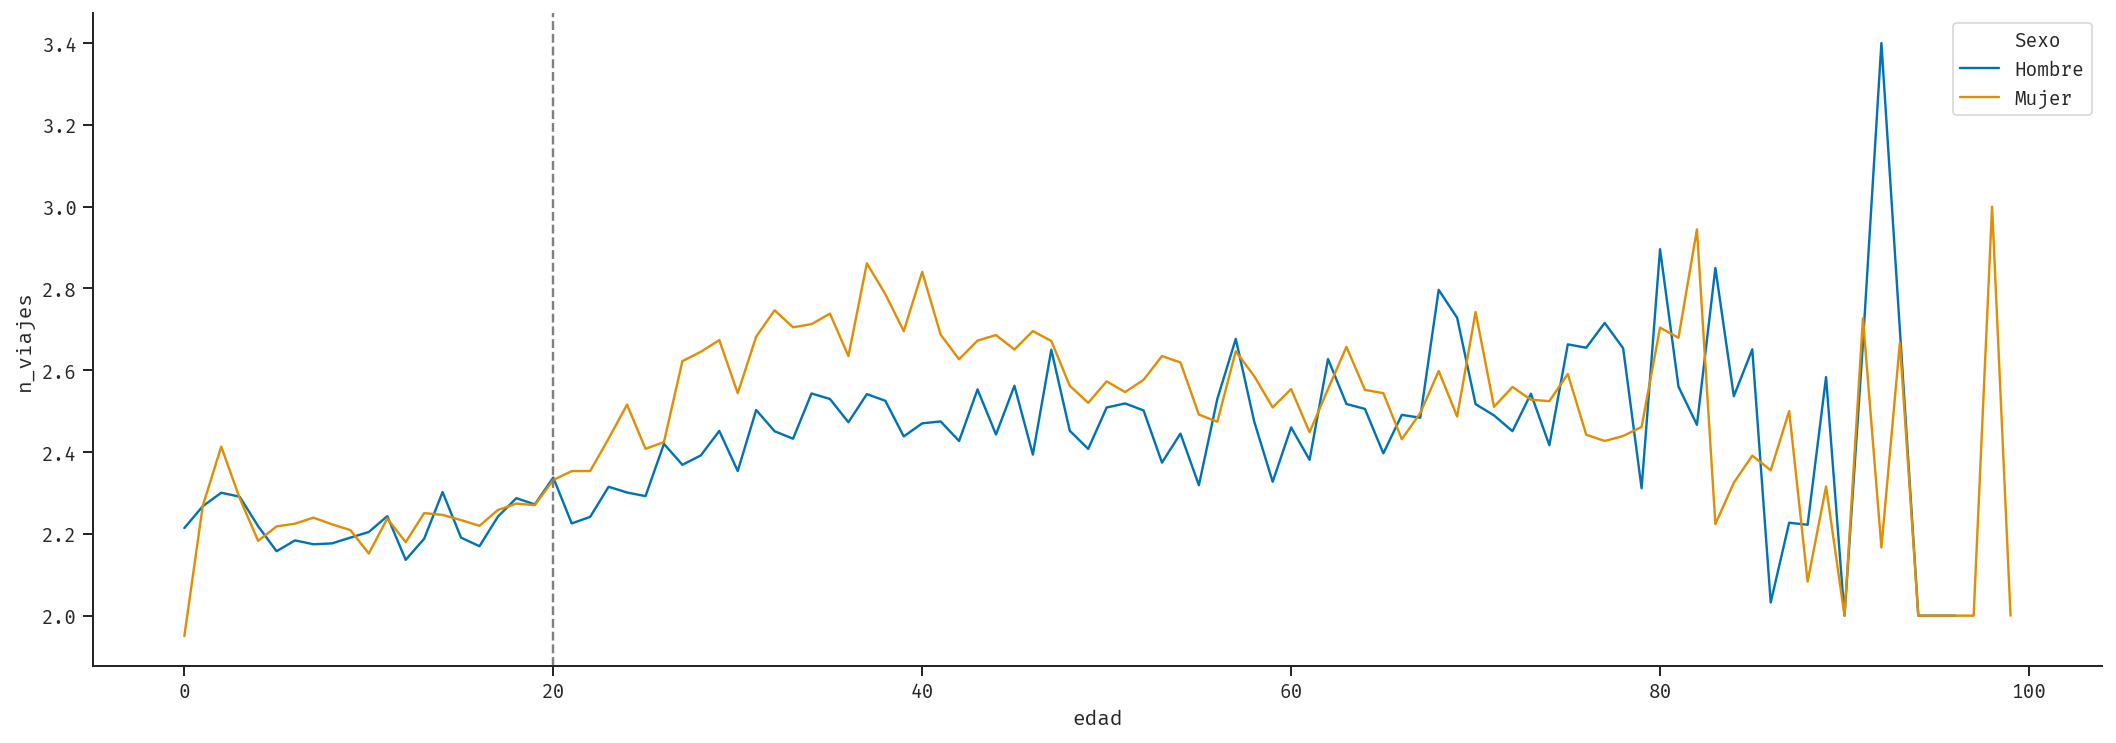

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.lineplot(x='edad', y='n_viajes', hue='Sexo', 
             data=n_viajes_age_gender[n_viajes_age_gender['n_viajes'] > 0],
             ci=None, ax=ax)
ax.axvline(x=20, linestyle='--', color='grey')
sns.despine(ax=ax)

Hay _tendencias_ distintas entre sexos. Esta diferencia cambia a medida que las personas pasan por distintas etapas de su vida. Durante la los primeros 20-25 años no existe una diferencia de género en la cantidad de viajes realizados. Sin embargo, a partir de los 30 (presumiblemente, la edad en que las mujeres comienzan a tener hijos), las mujeres realizan considerablemente más viajes que los hombres.

Sin embargo, la aseveración anterior es sólo hablando en términos de promedios. Si quisieramos mayor precisión estadística deberíamos considerar la variabilidad de los datos. Podemos hacer que `lineplot` incorpore una marca adicional con datos derivados: el intervalo de confianza del 95% de las observaciones

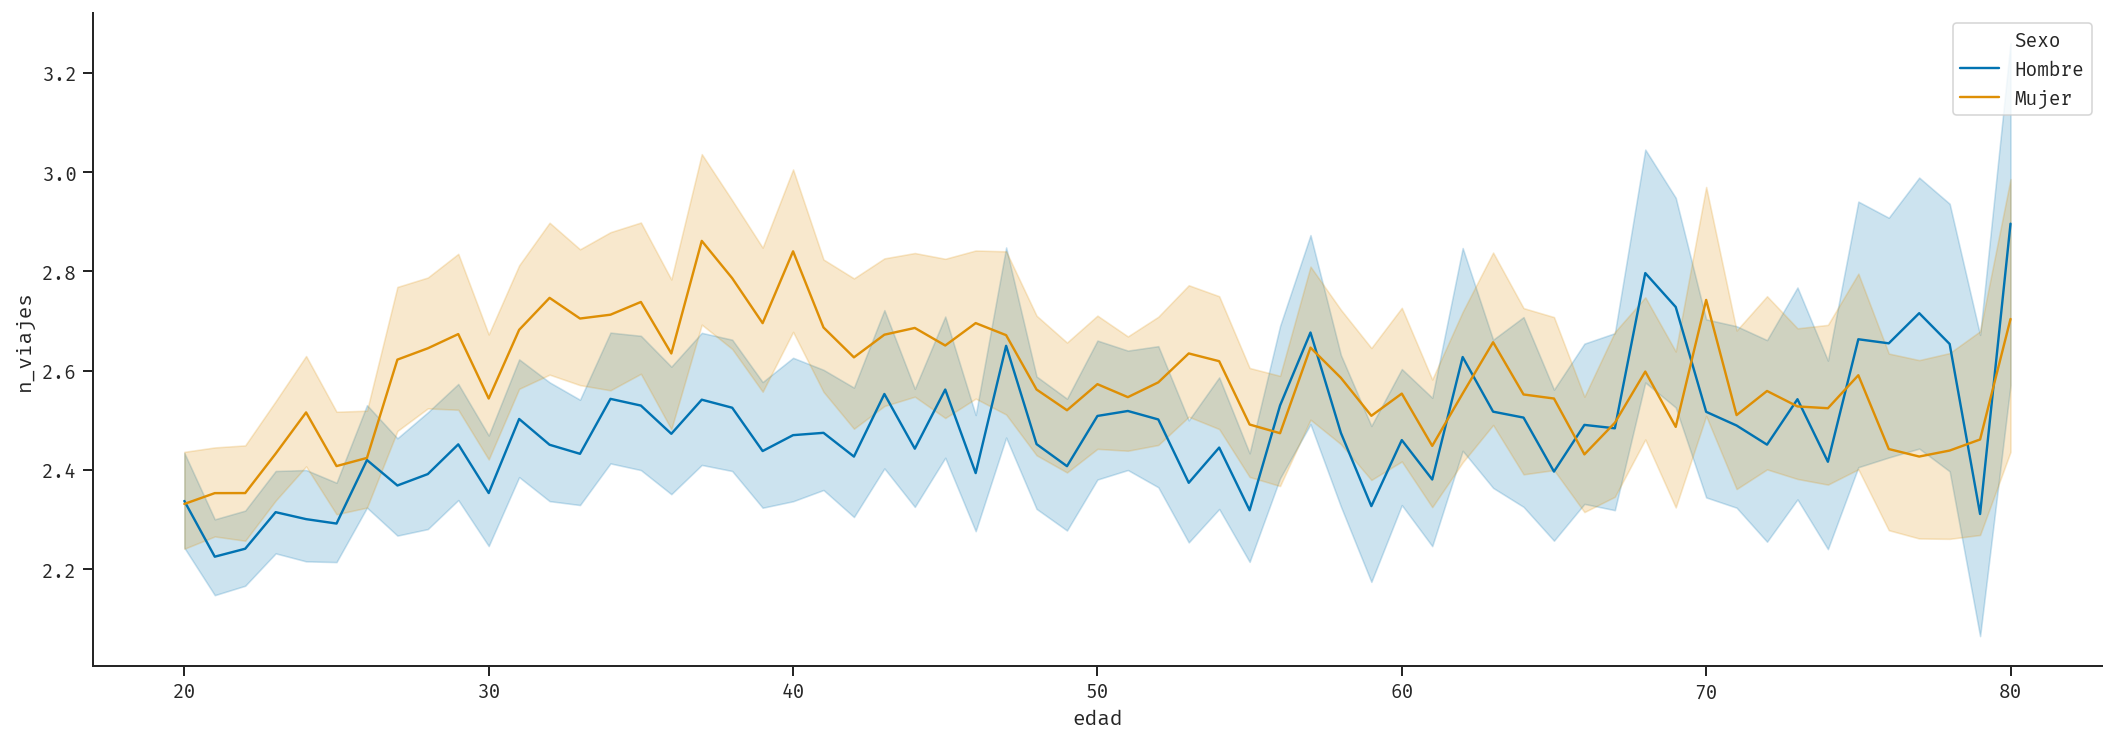

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.lineplot(x='edad', y='n_viajes', hue='Sexo', 
             data=n_viajes_age_gender[(n_viajes_age_gender['n_viajes'] > 0) & (n_viajes_age_gender['edad'].between(20, 80))],
             ci=95, ax=ax)
sns.despine(ax=ax)

En este caso, como los intervalos suelen estar intersectados, no hay información suficiente para determinar que existe una diferencia significativa entre hombres y mujeres. Sin embargo, hay edades para los que la diferencia sí podría ser significativa, lo que motiva a recolectar más datos para poder validar esta hipótesis.

#### ¿Cuál es la distribución de distancias recorridas por sector y género?

Ahora, pensemos en distancias. ¿Existe una diferencia de género en cuanto a las distancias recorridas, y hay alguna diferencia entre sectores de la ciudad? Lo lógico es que si consideramos la ubicación de los sectores laborales, las personas de sectores más periféricos de la ciudad recorran distancias más grandes que la gente que vive, por ejemplo, en el centro.

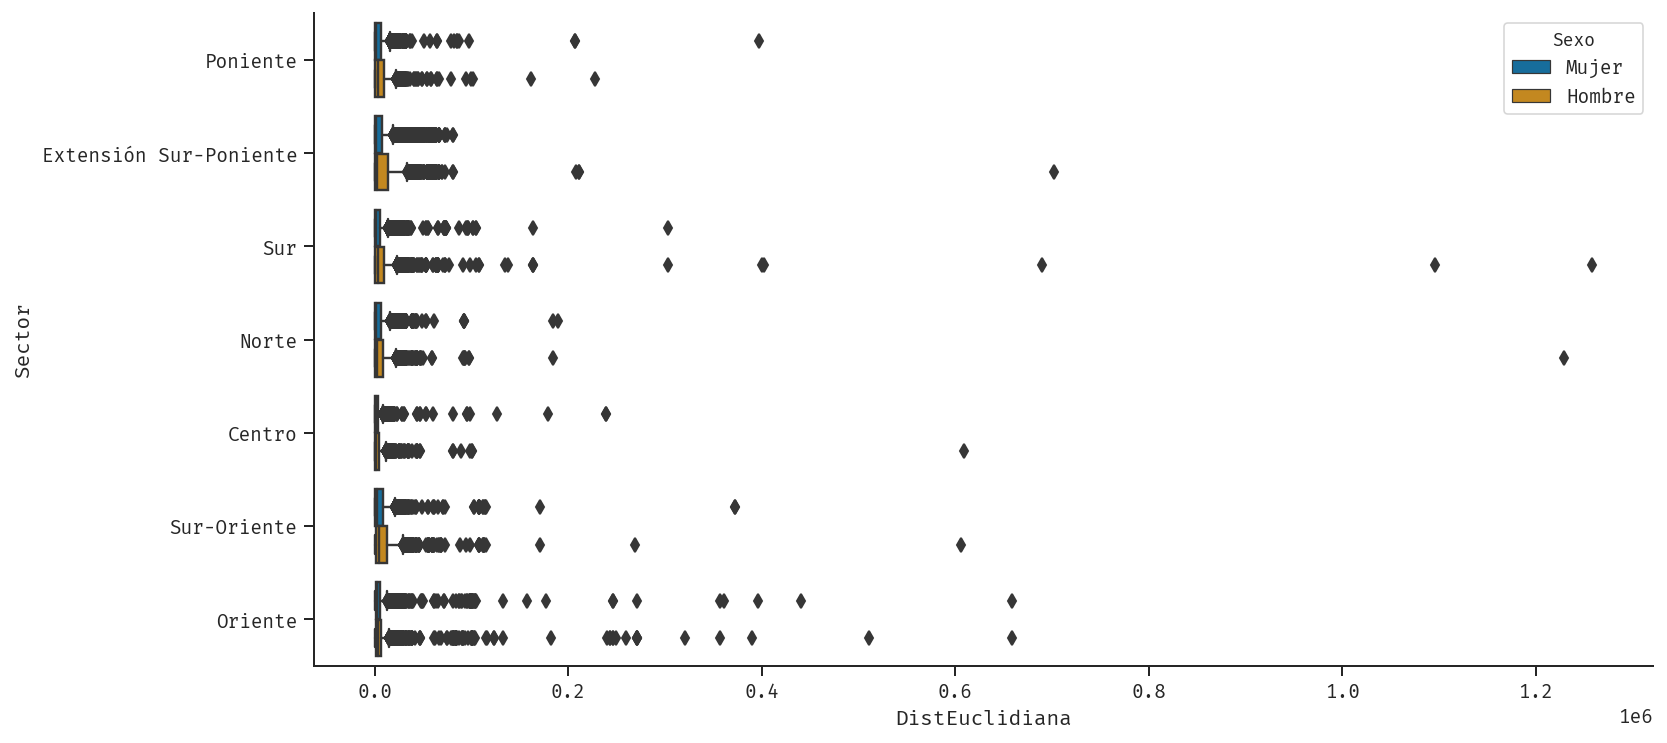

In [21]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(y='Sector', x='DistEuclidiana', hue='Sexo', data=tabla_completa)
sns.despine()

Usando este boxplot podemos ver la variabilidad de los datos, y detectar puntos atípicos. Por ejemplo, existe mayor cantidad de puntos atipicos con amplia variabilidad en el sector sur, que en el centro. Sin embargo, esto no nos permite ver la imagen completa de la distribución de las distancias.

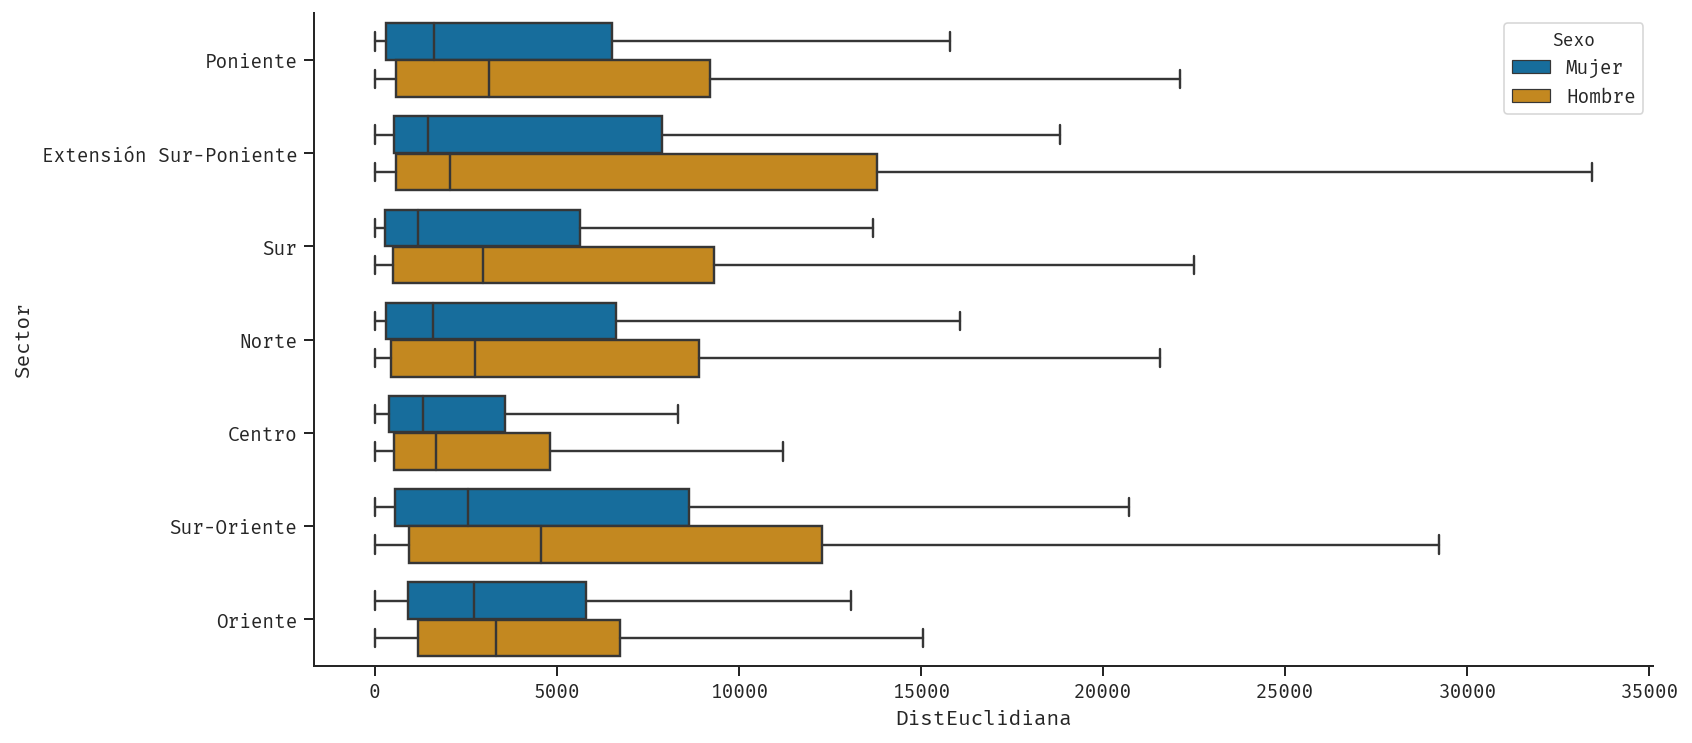

In [22]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(y='Sector', x='DistEuclidiana', hue='Sexo', data=tabla_completa, showfliers=False)
sns.despine()

Podemos notar que el promedio de distancias recorridas por hombres es más alto en todos los sectores de la ciudad. 

¿Qué pasa si incluimos la variable de propósito? Si pensamos que las mujeres realizan más viajes, aunque recorren distancias menores, mientras que los hombres recorren distancias más largas en menos viajes, probablemente la naturaleza de estos viajes es completamente distinta.

In [23]:
#Calculemos la media de la distancia por género y propósito
sexo_distancia = (tabla_completa
                  .groupby(['Proposito', 'Sexo'])['DistEuclidiana']
                  .median()
                  .rename('mediana').to_frame().reset_index())
sexo_distancia.head()

,Proposito,Sexo,mediana
0,Al estudio,Hombre,1720.0
1,Al estudio,Mujer,1634.0
2,Al trabajo,Hombre,6840.5
3,Al trabajo,Mujer,6138.5
4,Buscar o Dejar a alguien,Hombre,2048.0


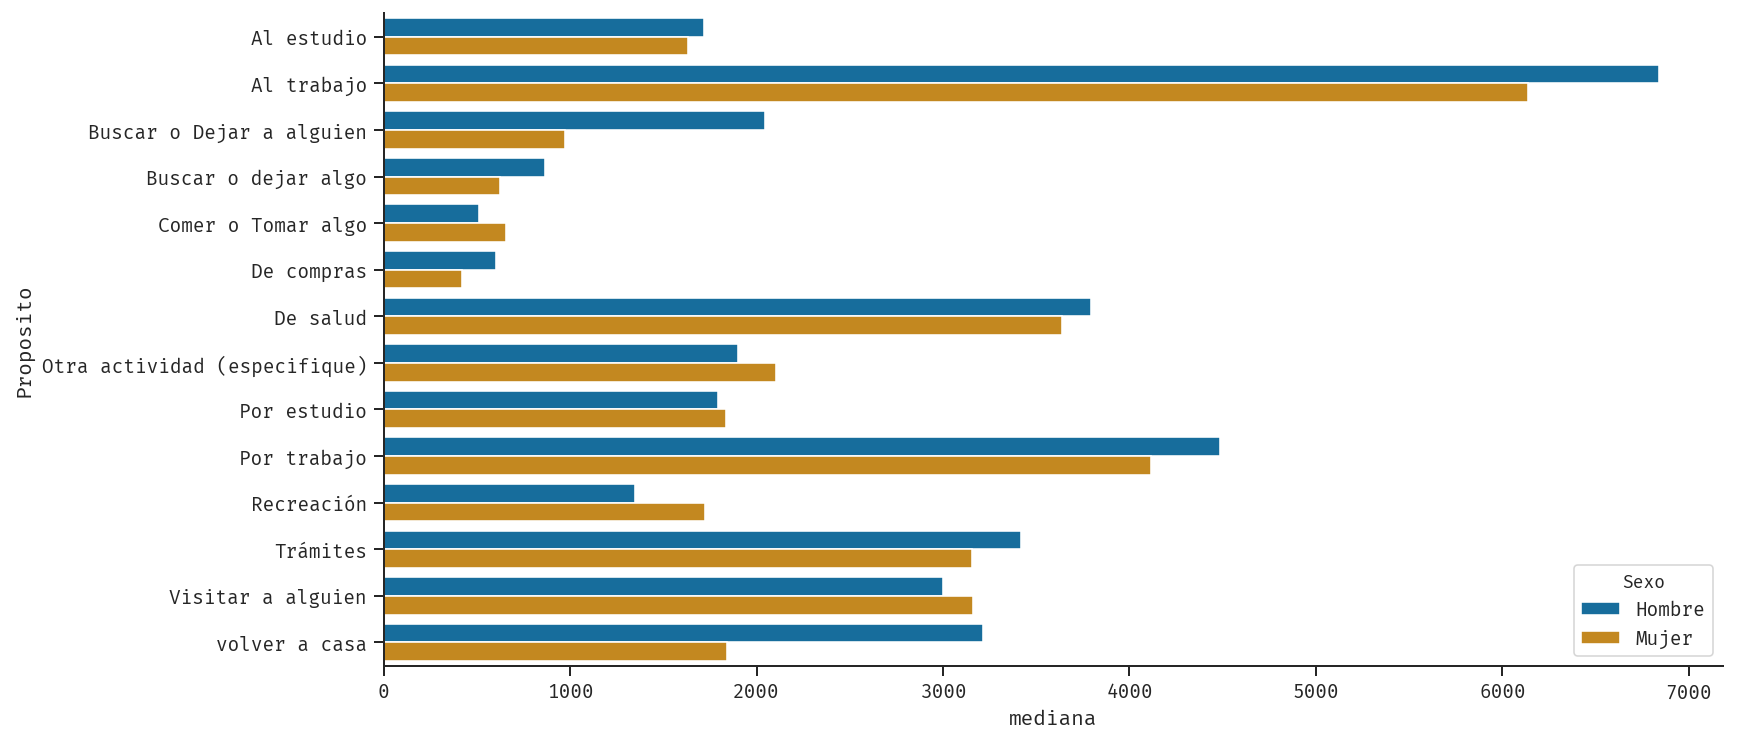

In [24]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="mediana", y="Proposito", hue="Sexo", data=sexo_distancia)
sns.despine()

Esto sirve pero es un poco complicado poder ver entre tanta categoría las verdaderas diferencias entre hombres y mujeres. Si lo que queremos ver es la diferencia podemos calcularla y visualizarla directamente.

In [25]:
distancia_proposito_sexo = sexo_distancia.pivot(index= 'Proposito', columns='Sexo', values='mediana')
distancia_proposito_sexo.head()

Sexo,Hombre,Mujer
Proposito,,
Al estudio,1720.0,1634.0
Al trabajo,6840.5,6138.5
Buscar o Dejar a alguien,2048.0,973.0
Buscar o dejar algo,866.0,622.0
Comer o Tomar algo,510.0,659.0


In [26]:
distancia_proposito_sexo['diferencia_distancia'] = distancia_proposito_sexo['Hombre'] - distancia_proposito_sexo['Mujer']
distancia_proposito_sexo.head()

Sexo,Hombre,Mujer,diferencia_distancia
Proposito,,,
Al estudio,1720.0,1634.0,86.0
Al trabajo,6840.5,6138.5,702.0
Buscar o Dejar a alguien,2048.0,973.0,1075.0
Buscar o dejar algo,866.0,622.0,244.0
Comer o Tomar algo,510.0,659.0,-149.0


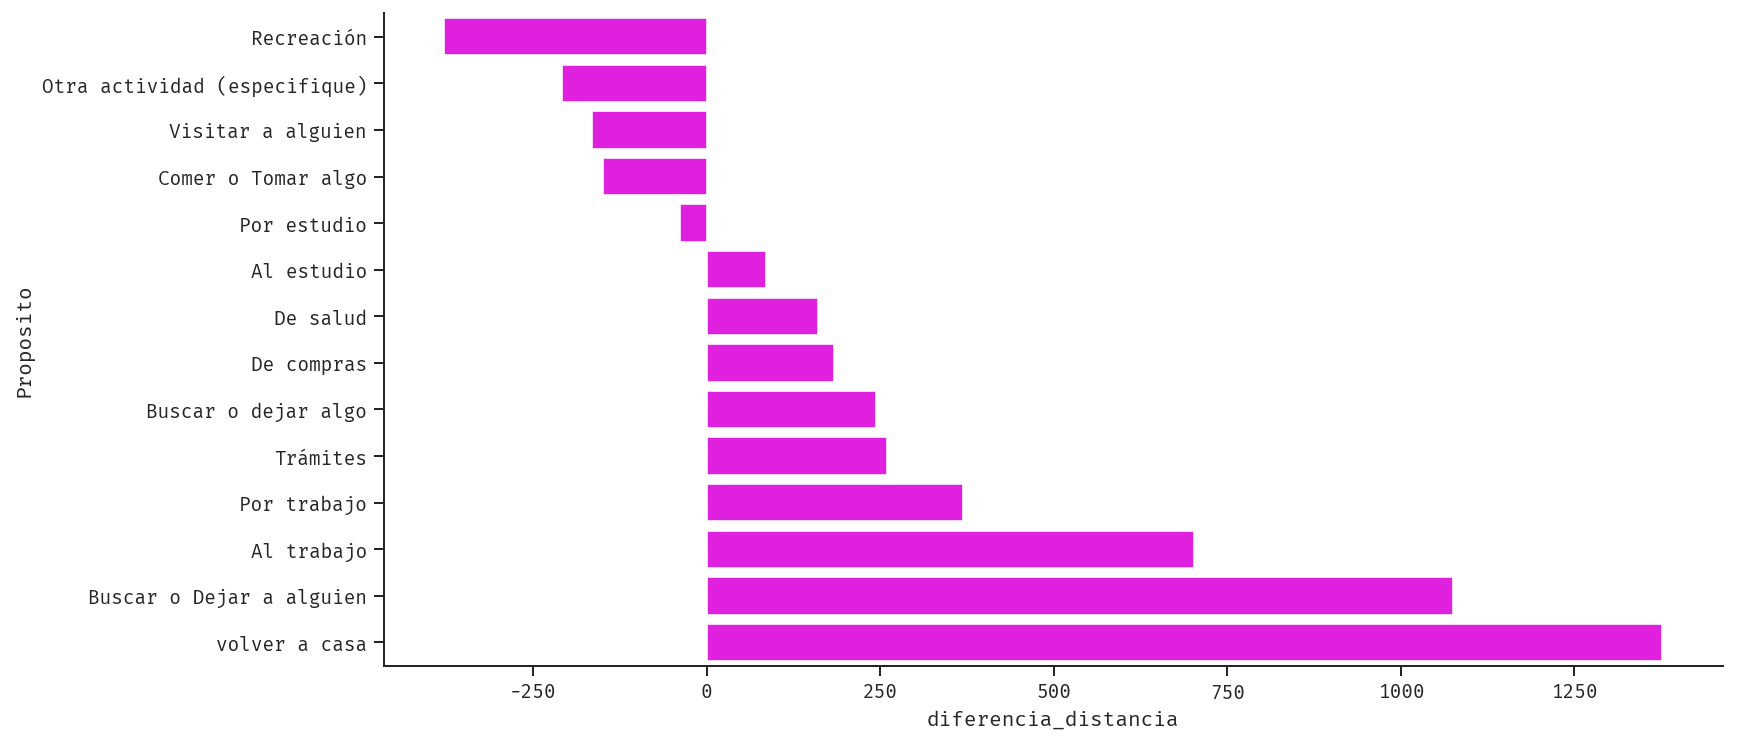

In [27]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="diferencia_distancia", y="Proposito", data=distancia_proposito_sexo.reset_index().sort_values('diferencia_distancia'), color='magenta')
sns.despine()

Esperaríamos que no hubiese diferencias en las distancias recorridas por sexo. Sin embargo, existen. Aquí vemos que hay propósitos de viaje para los que las mujeres recorren mayor distancia que los hombres, y viceversa. Si asumimos que una persona siempre preferirá ir al lugar más cercano, podemos plantear la hipótesis de que ir a una distancia mayor por un propósito de viaje implica una mayor asociatividad a ese tipo de viajes. 

Este gráfico llama a incluir más variables. Por ejemplo, ¿las mujeres deben viajar más por motivos de recreación?¿Se debe esto a que se recrean más, o a que deben facilitar la recreación de otras personas (como salir de paseo con sus hijos)?¿Por qué los hombres en promedio tienen trabajos que están más lejos?¿Cuál es la jornada de esos trabajos?¿Cuántos de estos viajes son acompañados?

Estamos en presencia de una visualización que nos plantea más preguntas que respuestas. Eso es bueno.

Veamos la distribución de propósitos de viaje por sexo para ahondar un poco más en este fenómeno. Porque quizás existe un propósito que tenga mayor distancia para un sexo, pero que en realidad sea efectuado en menor proporción con respecto al otro sexo.

In [28]:
sexo_propositos = (tabla_completa
                     .groupby(['Proposito', 'Sexo'])
                     .apply(lambda x: (x['FactorPersona'] * x['FactorLaboralNormal']).sum())
                     .unstack(fill_value=0)
                     .pipe(normalize_rows)
                     .assign(diferencia_viajes=lambda x: x['Hombre'] - x['Mujer'])
)

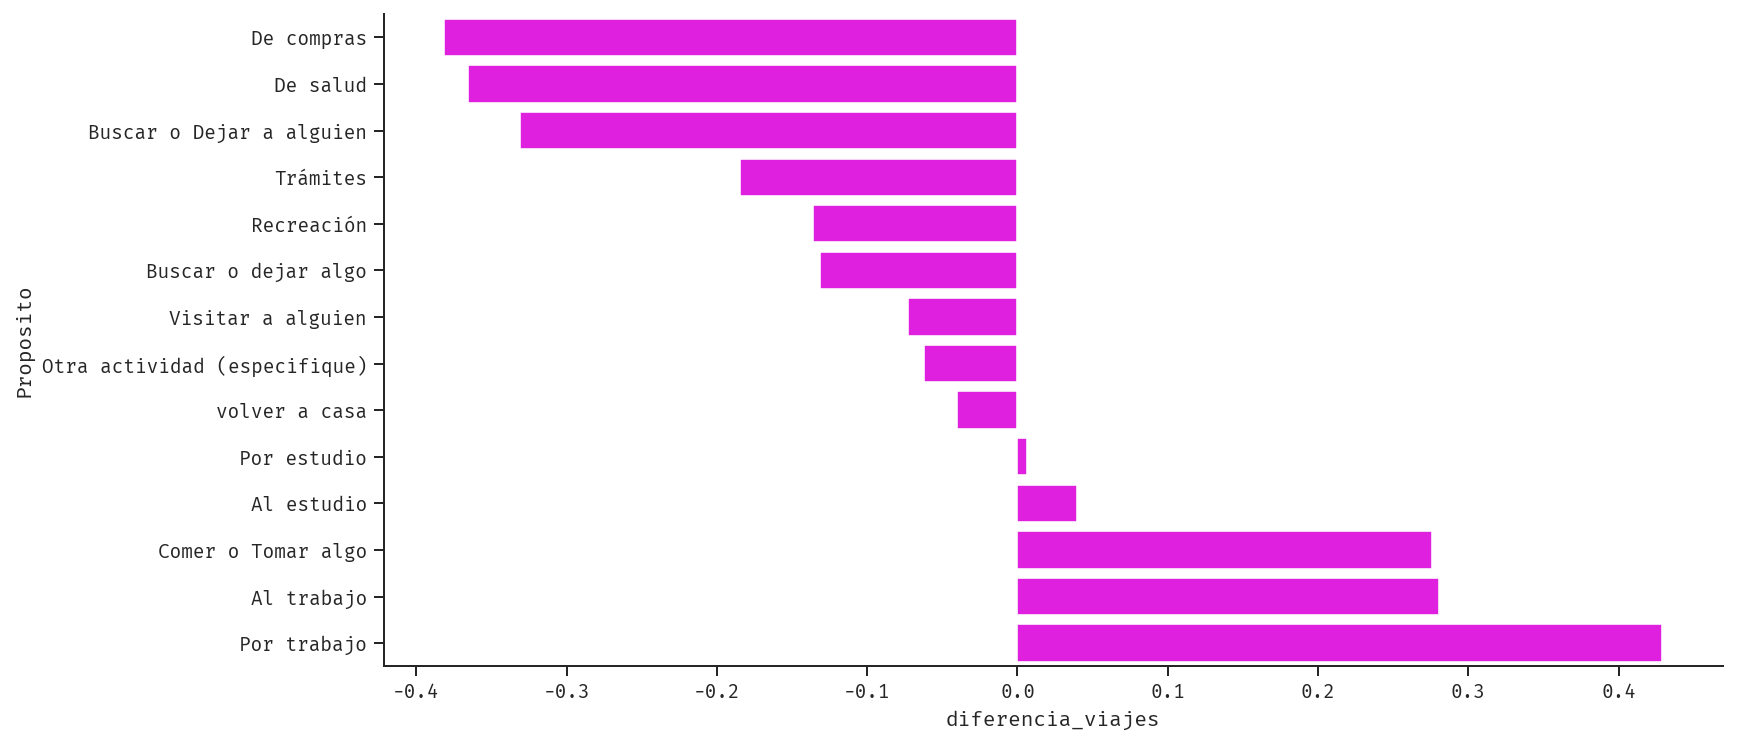

In [29]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="diferencia_viajes", y="Proposito", data=sexo_propositos.reset_index().sort_values('diferencia_viajes'), color='magenta')
sns.despine()

Como tenemos dos variables que por sí mismas son interesantes, pero necesitamos saber la relación entre ellas, podemos acudir a un `scatterplot` utilizando esas dos variables como atributos cuantitativos.

In [30]:
distancia_proposito = sexo_propositos.join(distancia_proposito_sexo['diferencia_distancia'])

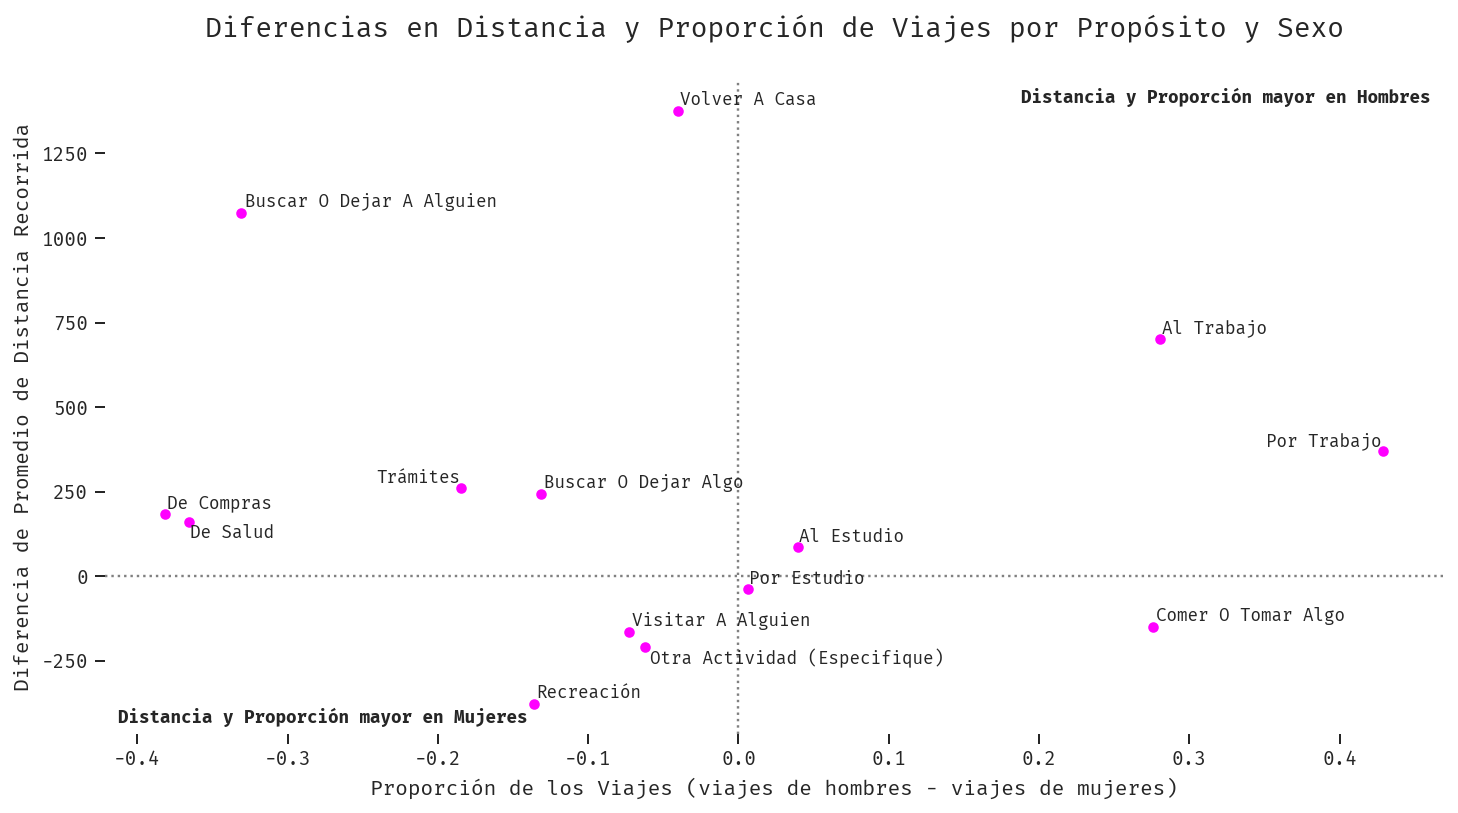

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.axvline(x=0, color='grey', linestyle='dotted', zorder=0)
ax.axhline(y=0, color='grey', linestyle='dotted', zorder=0)
distancia_proposito.plot(x='diferencia_viajes', y='diferencia_distancia', kind='scatter', ax=ax, color='magenta')

labels = []

for index, row in distancia_proposito.iterrows():
    text = ax.annotate(index.title(), (row['diferencia_viajes'], row['diferencia_distancia']), fontsize='small')
    labels.append(text)
    
# esta biblioteca externa nos ayuda a darle legibilidad al texto
adjust_text(labels, ax=ax, lim=5)

ax.annotate('Distancia y Proporción mayor en Hombres', (0.99, 0.99), xycoords='axes fraction', fontsize='small', fontweight='bold', ha='right', va='top')
ax.annotate('Distancia y Proporción mayor en Mujeres', (0.01, 0.01), xycoords='axes fraction', fontsize='small', fontweight='bold', ha='left', va='bottom')

ax.set_title('Diferencias en Distancia y Proporción de Viajes por Propósito y Sexo', fontsize=14, y=1.05)
ax.set_xlabel('Proporción de los Viajes (viajes de hombres - viajes de mujeres)')
ax.set_ylabel('Diferencia de Promedio de Distancia Recorrida')

sns.despine(left=True, right=True, top=True, bottom=True, ax=ax)

¿Qué concluyen a partir de esta visualización?¿Qué preguntas nuevas tienen?

**Nota**: en este análisis no hemos considerado los factores de expansión. Por tanto, es un análisis que se aplica a quienes respondieron la encuesta, no a la población.

### 2. ¿Cuáles son los patrones de propósitos de viaje por comuna y cómo se relacionan entre ellas?

Hasta ahora hemos analizado los datos sin tener en consideración las diferencias en el tamaño de cada uno de los grupos (hombres vs mujeres). Las siguientes visualizaciones las realizaremos normalizando sobre el total de datos para poder hacer comparaciones, y además, teniendo en cuenta los factores de expansión.

Primero, veamos cuáles son los propósitos de viaje asociados a cada comuna de destino. Esto nos diría cosas del estilo "Santiago está más asociada a viajes de trabajo que otras comunas".

In [32]:
comuna_propositos = (tabla_completa
                     .groupby(['ComunaDestino', 'Proposito'])
                     .apply(lambda x: (x['FactorPersona'] * x['FactorLaboralNormal']).sum())
                     .unstack(fill_value=0)
)

Si queremos ver la distribución de propósitos por comuna, queremos efectuar una tarea de medir `parte-de-un-todo` y de comparar dichas partes. Podemos utilizar el `stacked_bar_chart` para ello:

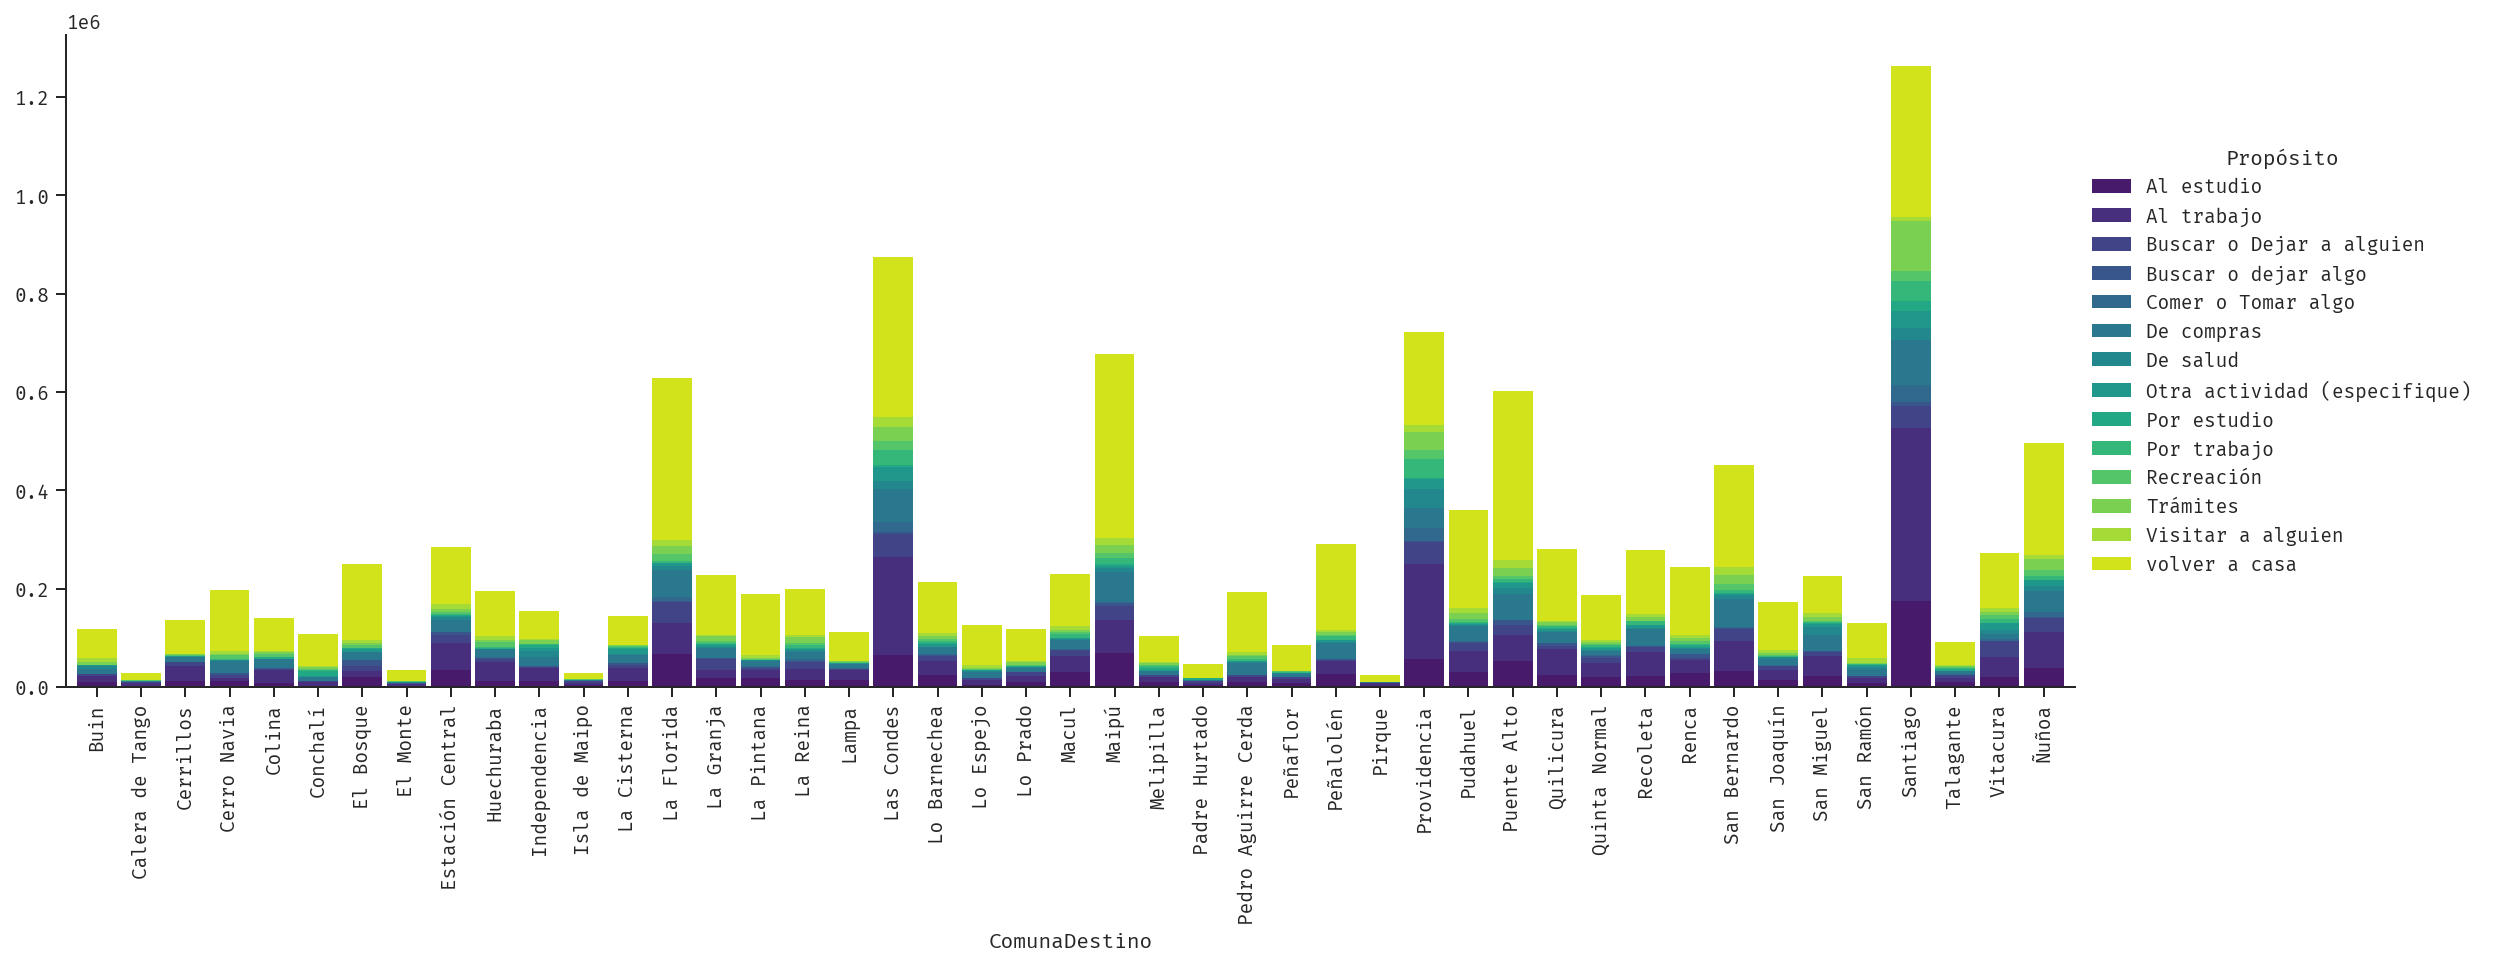

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.set_palette('viridis', n_colors=len(comuna_propositos.columns))
comuna_propositos.plot(kind='bar', stacked=True, ax=ax, width=0.9, edgecolor='none')
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Propósito', frameon=False)
sns.despine(ax=ax)

Notamos algunos problemas con el gráfico. Primero, tenemos muchísimas categorías (propósitos de viaje), lo que dificulta la elección de paleta de colores. Si asumimos que la que se eligió está bien, el siguiente problema es que los tamaños y poblaciones de cada comuna están influyendo en la tarea comparación.

Una manera de resolver esto es normalizando la tabla por filas (es decir, por comuna) y utilizar el `normalized_stacked_area_chart`:

In [34]:
normalized_comuna_propositos = comuna_propositos.pipe(normalize_rows)

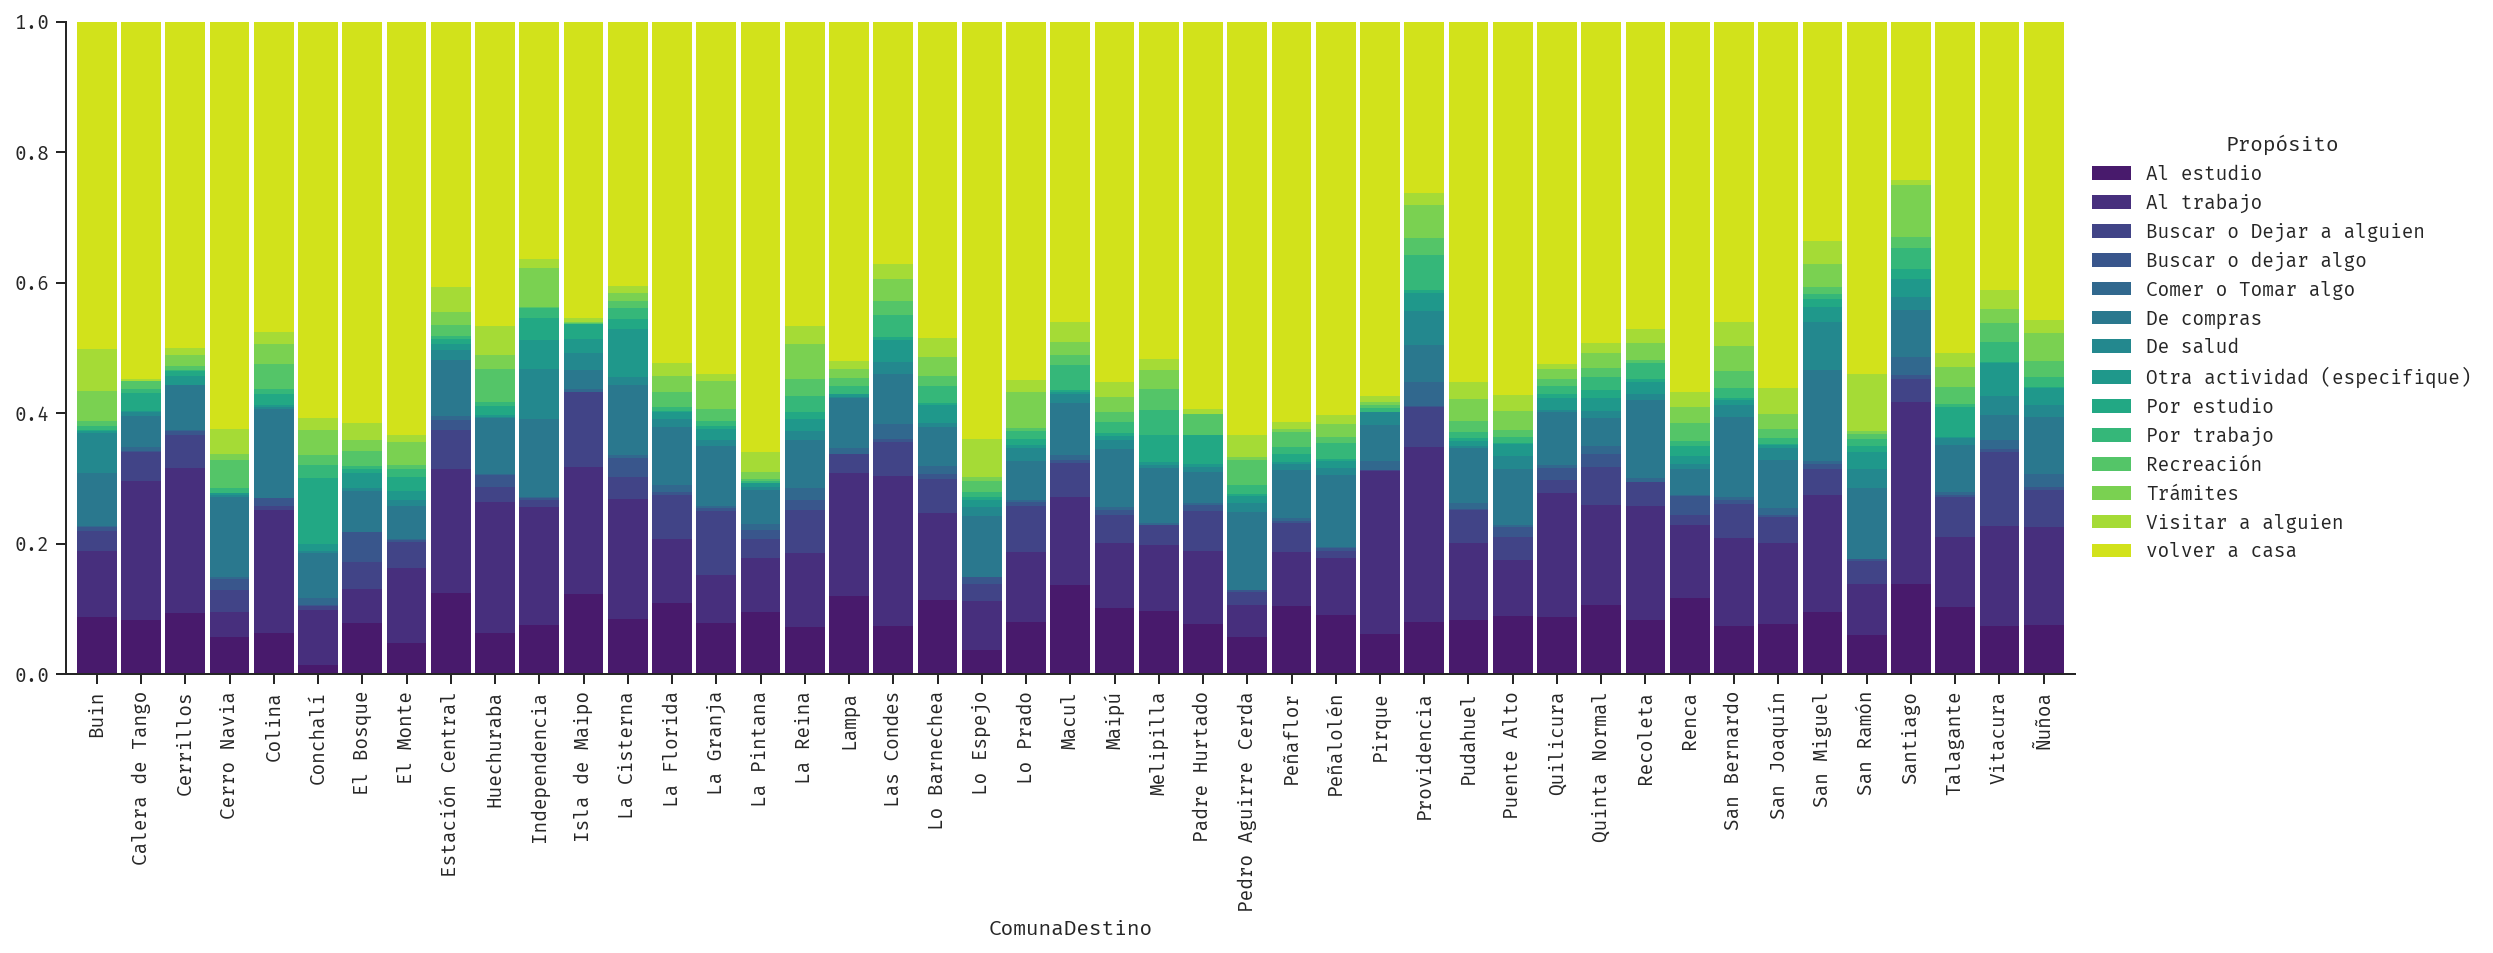

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
normalized_comuna_propositos.plot(kind='bar', stacked=True, ax=ax, edgecolor='none', width=0.9)
ax.set_ylim([0, 1])
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Propósito', frameon=False)
sns.despine(ax=ax)

¡Este gráfico está mejor! Sin embargo, seguimos con el problema de tener demasiadas categorías.

Si ya resolvimos la tarea `parte-de-un-todo`, podemos probar un `heatmap` para visualizar la tabla. Probemos como luce:

<AxesSubplot:xlabel='Proposito', ylabel='ComunaDestino'>

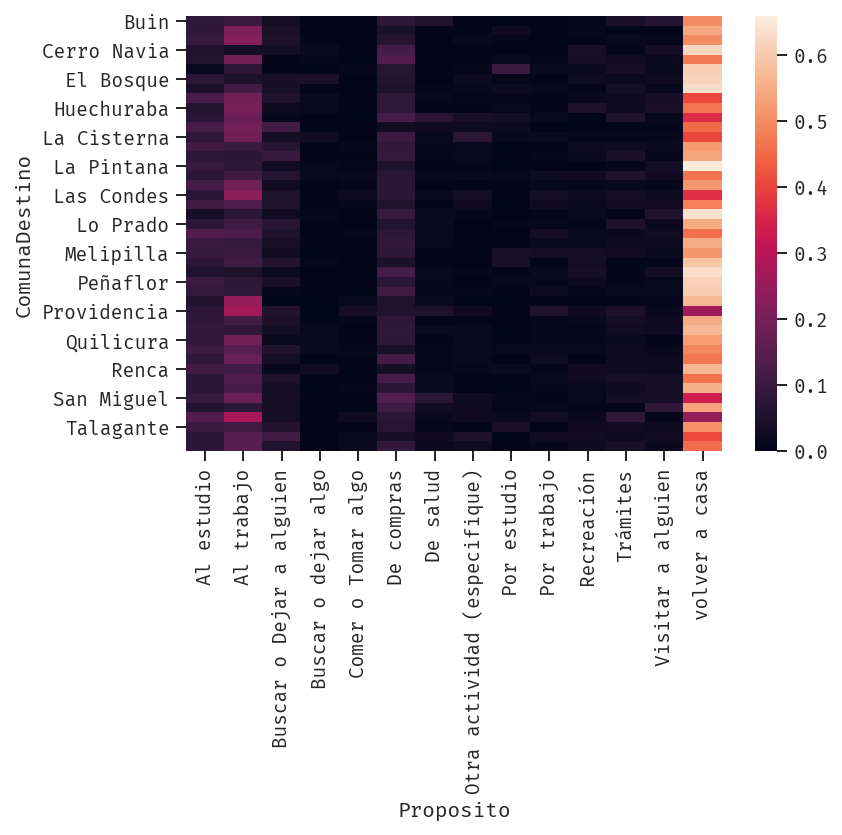

In [36]:
sns.heatmap(normalized_comuna_propositos)

Notamos que no pareciera no haber variabilidad entre columnas. Esto se debe a que las distribuciones no varían _tanto_ en términos absolutos. Como lo que queremos saber es si una comuna recibe más viajes de cierto propósito _que las otras comunas_, podemos utilizar el _puntaje estándar_ o _z-score_ para cuantificar ese fenómeno:

In [37]:
standardized_comuna_propositos = normalized_comuna_propositos.pipe(standardize_columns)

<AxesSubplot:xlabel='Proposito', ylabel='ComunaDestino'>

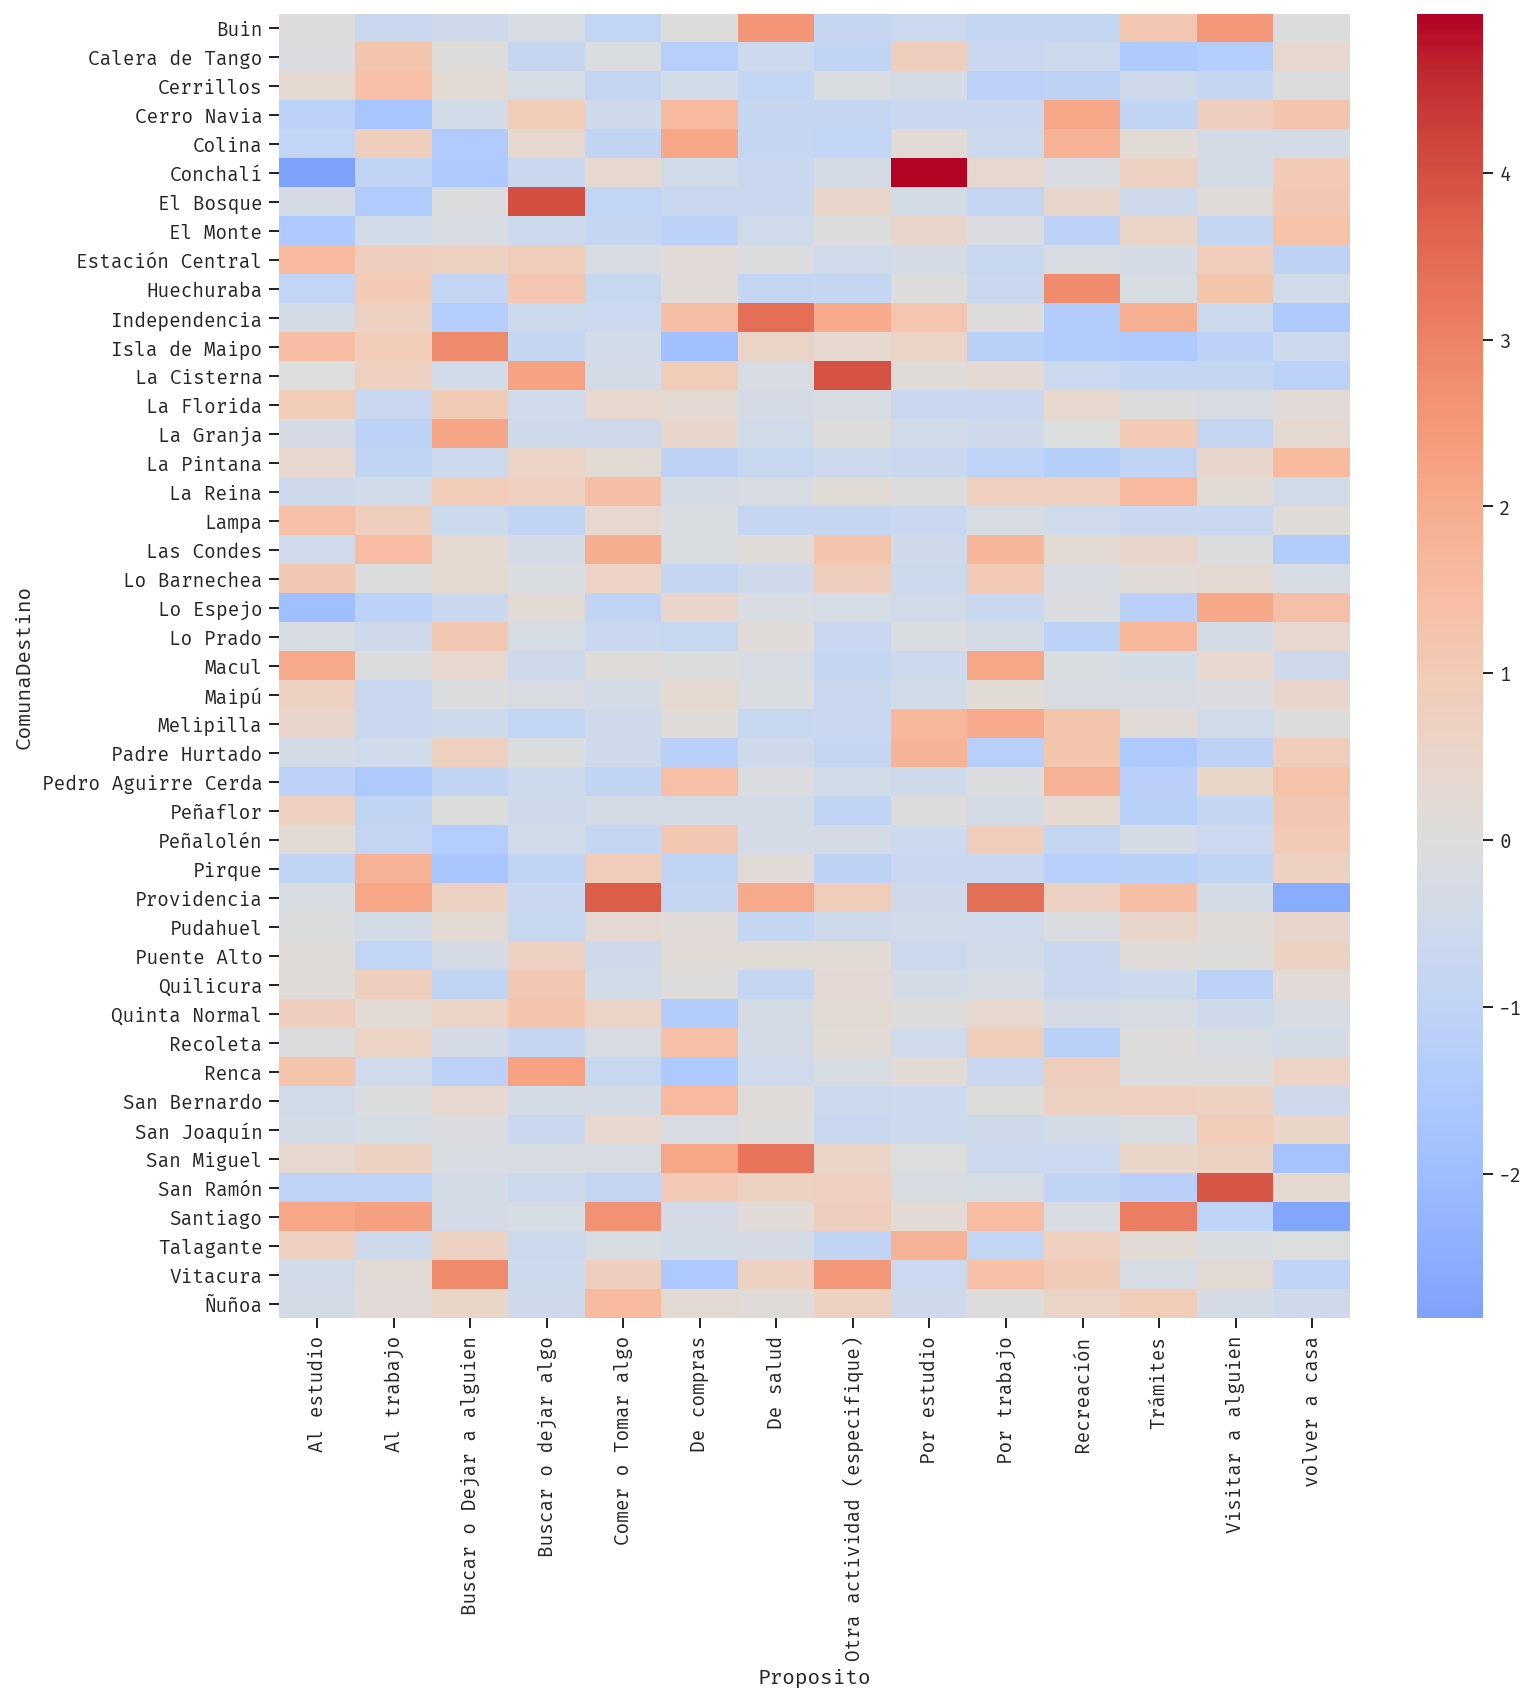

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(standardized_comuna_propositos, center=0, cmap='coolwarm', ax=ax)

La derivación del puntaje estándar genera un atributo cuantitativo `divergente`. Por ello hemos utilizado una paleta de ese estilo. Noten que esto nos permite identificar rápidamente cuales comunas están más asociadas a cada propósito, porque tenemos que buscar las celdas con un color más saturado. El tono nos dirá la dirección que toma respecto al punto de origen.

Si queremos agrupar comunas y propósitos para encontrar patrones dentro de esta tabla, podemos utilizar el `clustermap`:

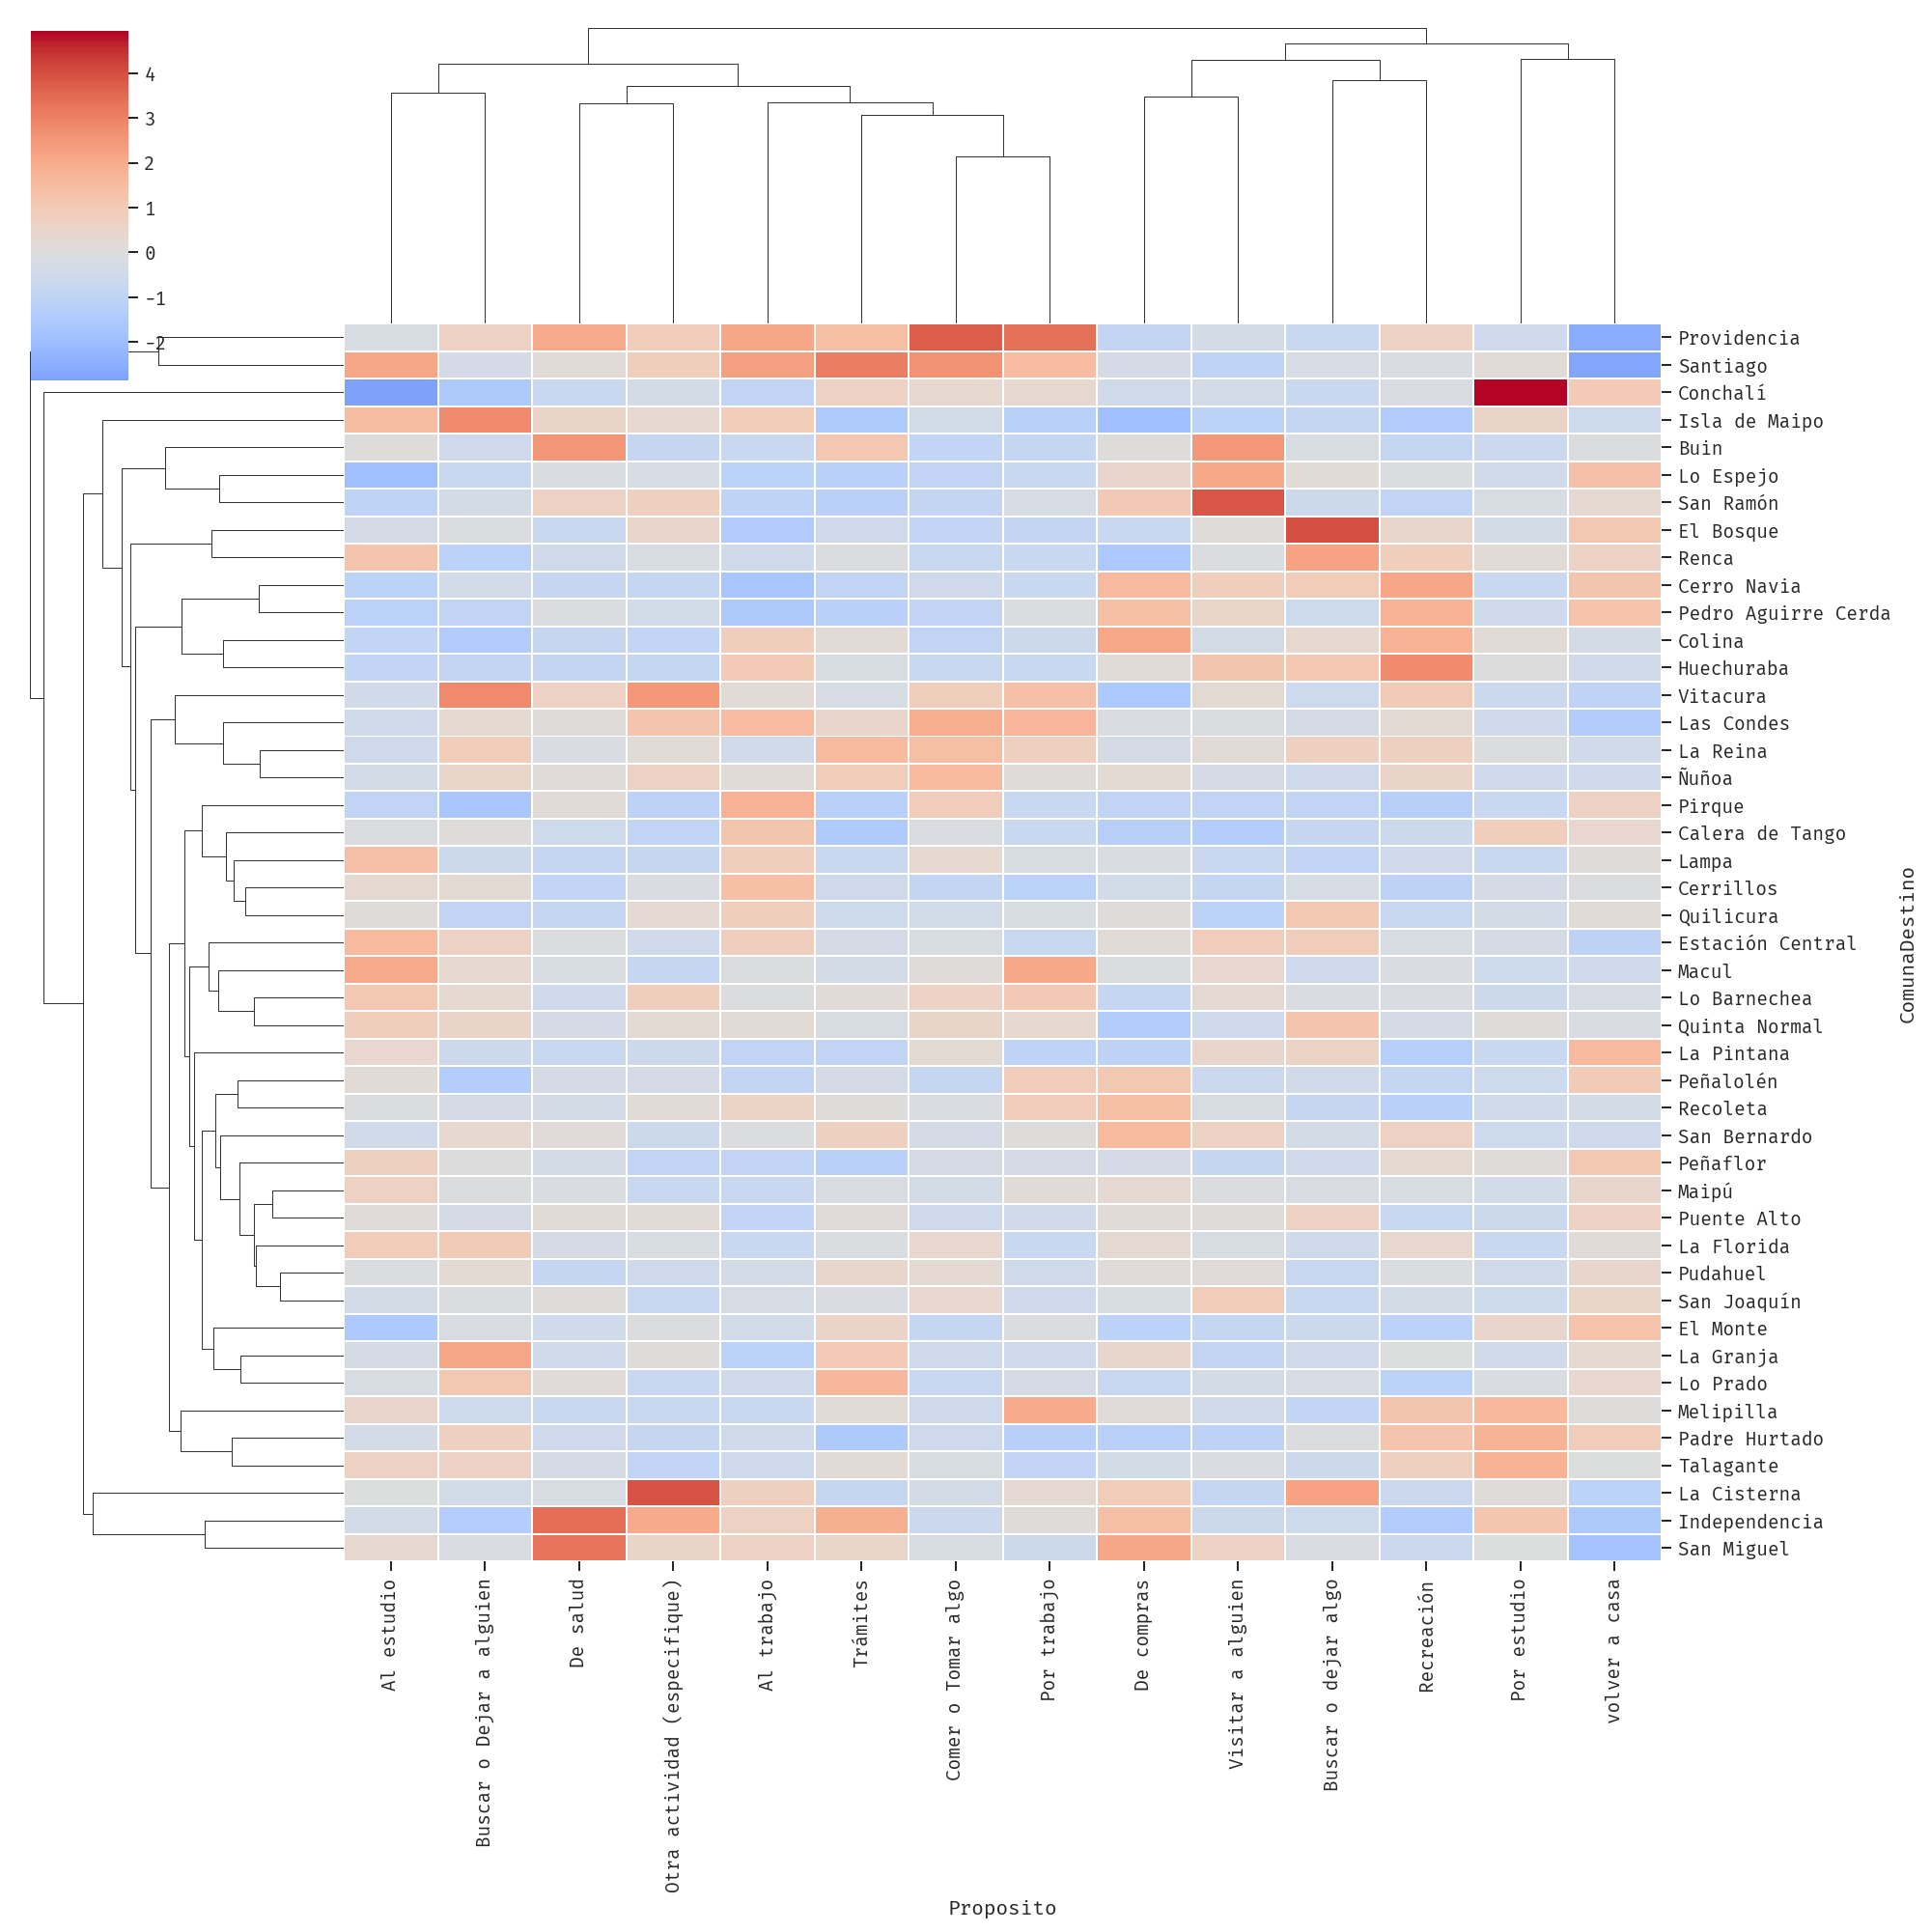

In [39]:
sns.clustermap(standardized_comuna_propositos, center=0, figsize=(14, 14), linewidth=0.5, cmap='coolwarm')

En este caso, esta visualización nos permite ver de manera más claras los grupos de comuna de acuerdo a propósito de viaje. ¿Qué ven ustedes aquí? ¿Les hacen sentido estos grupos?

#### ¿De dónde provienen las personas para cada propósito de viaje?

Ahora, utilicemos un heatmap para ver las relaciones entre comuna de origen y comuna de destino, de acuerdo a cada propósito particular. Esto es lo que se conoce como **matriz origen-destino** y es uno de los resultados más importantes de la encuesta.

In [40]:
comuna_od = (tabla_completa
                     .groupby(['Proposito', 'Comuna', 'ComunaDestino'])
                     .apply(lambda x: (x['FactorPersona'] * x['FactorLaboralNormal']).sum())
                     .unstack(fill_value=0)
                     .pipe(normalize_rows)
)

Así luce esta tabla:

In [41]:
comuna_od.head()

ComunaDestino                   Buin  Calera de Tango  Cerrillos  Cerro Navia  \
Proposito  Comuna                                                               
Al estudio BUIN             0.718381         0.000000   0.000135     0.000000   
           CALERA DE TANGO  0.000000         0.837071   0.000000     0.000000   
           CERRILLOS        0.000000         0.000000   0.398699     0.000000   
           CERRO NAVIA      0.000000         0.000000   0.000000     0.396231   
           COLINA           0.000000         0.000000   0.000000     0.000000   

ComunaDestino                 Colina  Conchalí  El Bosque  El Monte  \
Proposito  Comuna                                                     
Al estudio BUIN             0.000000       0.0        0.0       0.0   
           CALERA DE TANGO  0.000000       0.0        0.0       0.0   
           CERRILLOS        0.000000       0.0        0.0       0.0   
           CERRO NAVIA      0.000000       0.0        0.0       0.0   
           COLINA           0.996363       0.0        0.0       0.0   

ComunaDestino               Estación Central  Huechuraba  ...  Recoleta  \
Proposito  Comuna                                         ...             
Al estudio BUIN                     0.000000         0.0  ...       0.0   
           CALERA DE TANGO          0.004886         0.0  ...       0.0   
           CERRILLOS                0.105648         0.0  ...       0.0   
           CERRO NAVIA              0.016525         0.0  ...       0.0   
           COLINA                   0.002426         0.0  ...       0.0   

ComunaDestino                  Renca  San Bernardo  San Joaquín  San Miguel  \
Proposito  Comuna                                                             
Al estudio BUIN             0.000000      0.004861          0.0    0.000000   
           CALERA DE TANGO  0.000000      0.017061          0.0    0.000000   
           CERRILLOS        0.000000      0.000000          0.0    0.093399   
           CERRO NAVIA      0.038293      0.000000          0.0    0.000000   
           COLINA           0.000000      0.000000          0.0    0.000000   

ComunaDestino               San Ramón  Santiago  Talagante  Vitacura     Ñuñoa  
Proposito  Comuna                                                               
Al estudio BUIN                   0.0  0.241160   0.000000       0.0  0.000000  
           CALERA DE TANGO        0.0  0.109538   0.007035       0.0  0.002026  
           CERRILLOS              0.0  0.117227   0.000000       0.0  0.002949  
           CERRO NAVIA            0.0  0.115314   0.000000       0.0  0.089214  
           COLINA                 0.0  0.000721   0.000000       0.0  0.000000  

[5 rows x 45 columns]

Nos dice para cada comuna de origen cuál es la proporción de viajes que fueron a cada comuna de destino, de acuerdo al propósito de viaje.

En tiempos de COVID nos interesa saber cómo son los viajes por temas de salud. Podemos visualizar esta tabla con un `heatmap`, puesto que tenemos dos llaves categóricas (las comunas de origen y destino) y un atributo cuantitativo (la proporción de viajes):

<AxesSubplot:xlabel='ComunaDestino', ylabel='Comuna'>

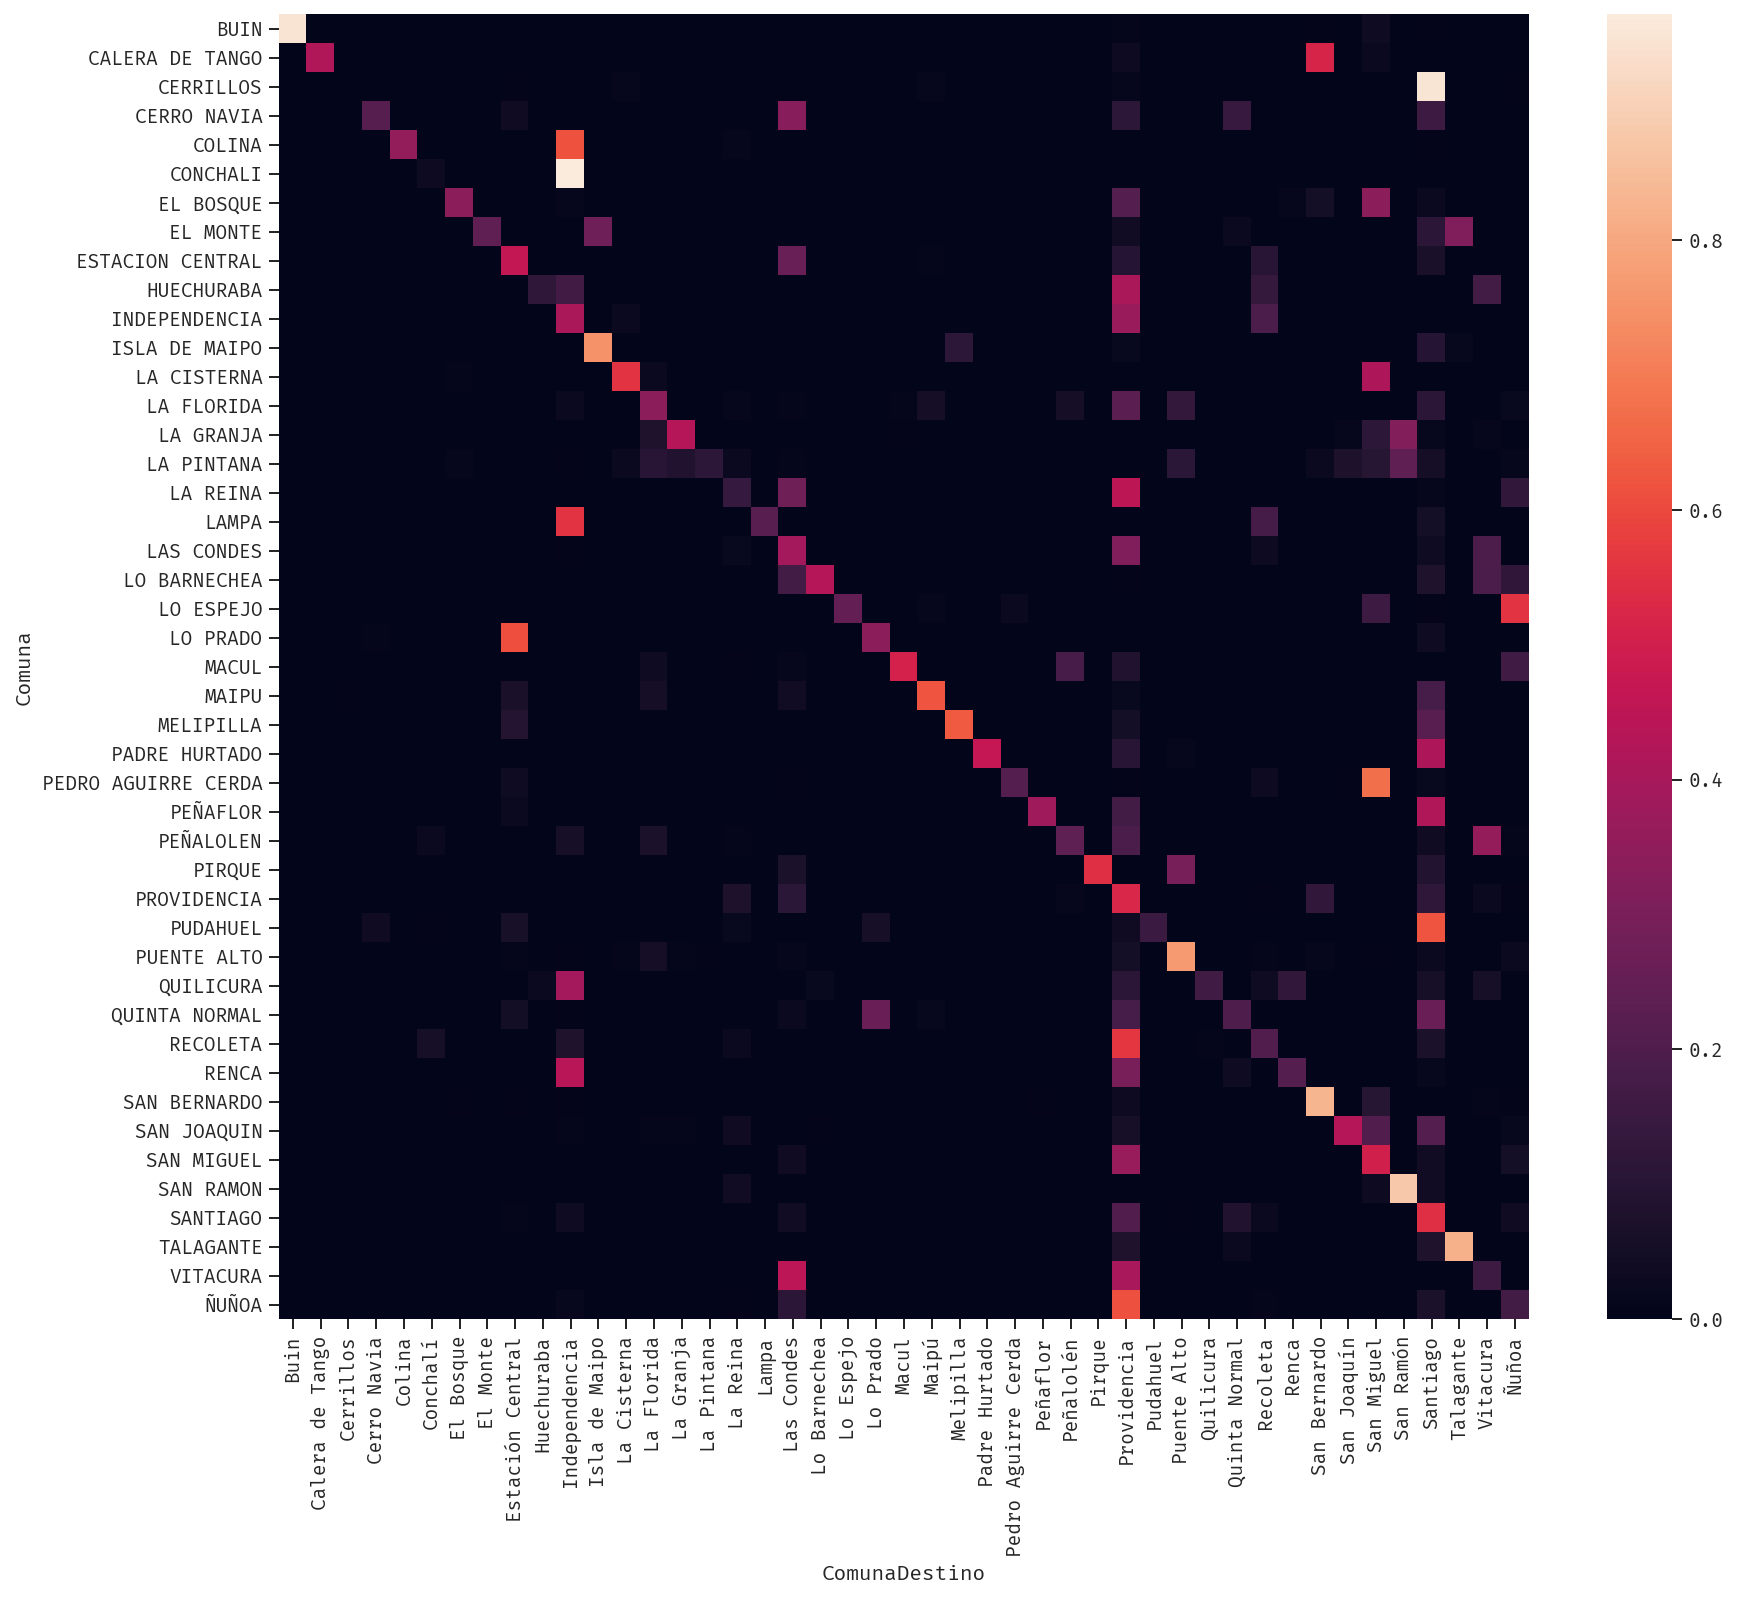

In [42]:
plt.figure(figsize=(14, 12))
sns.heatmap(comuna_od.loc['De salud'])

La mayoría de los viajes en cada comuna se da dentro de sí misma (en la diagonal). Eso se explica por los viajes de atención primaria. 

También hay relaciones entre comunas aledañas, como por ejemplo Conchalí-Independencia, Cerrillos-Santiago. ¡Sorpresivamente los habitantes de Ñuñoa realizan más viajes de salud a Providencia que a su misma comuna!

Si queremos ver patrones de grupos de comunas respecto a estos viajes, podemos usar `clustermap` nuevamente:

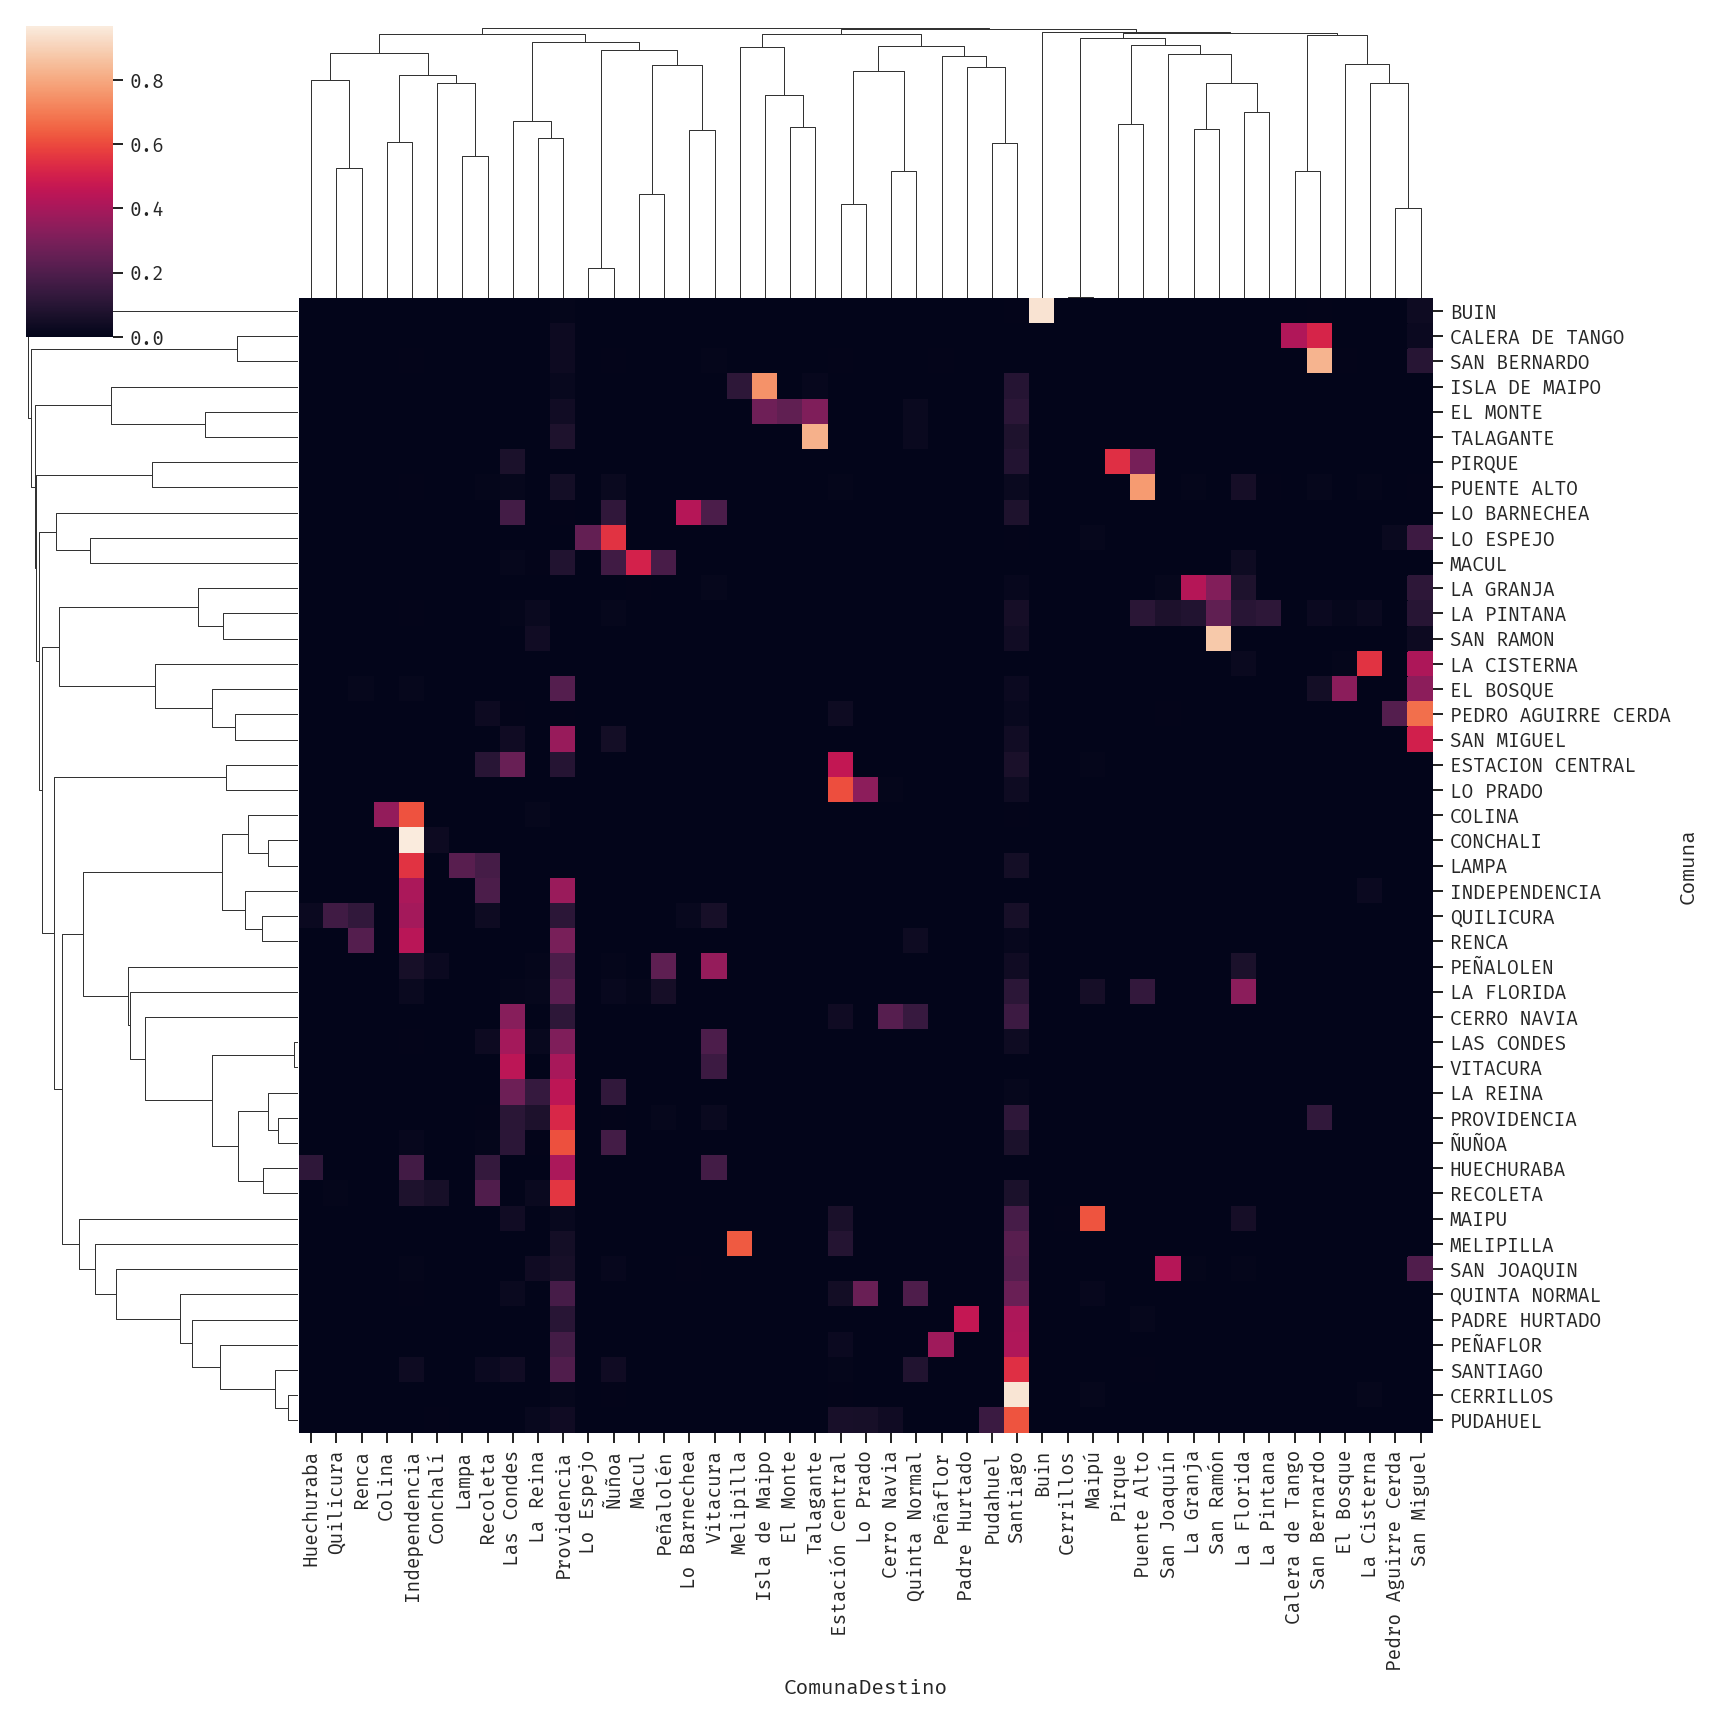

In [43]:
sns.clustermap(comuna_od.loc['De salud'], metric='correlation', figsize=(12,12))

Es interesante usar esta técnica porque al utilizar el clustering mapea grupos de comunas cercanas y sus interacciones. Las comunas que agrupan viajes de otras comunas son cercanas entre sí y tienen hospitales o clínicas. Es decir, agrupan viajes de atención más especializada o más grave.

Utilicemos el mismo enfoque para encontrar las comunas que concentran trabajos:

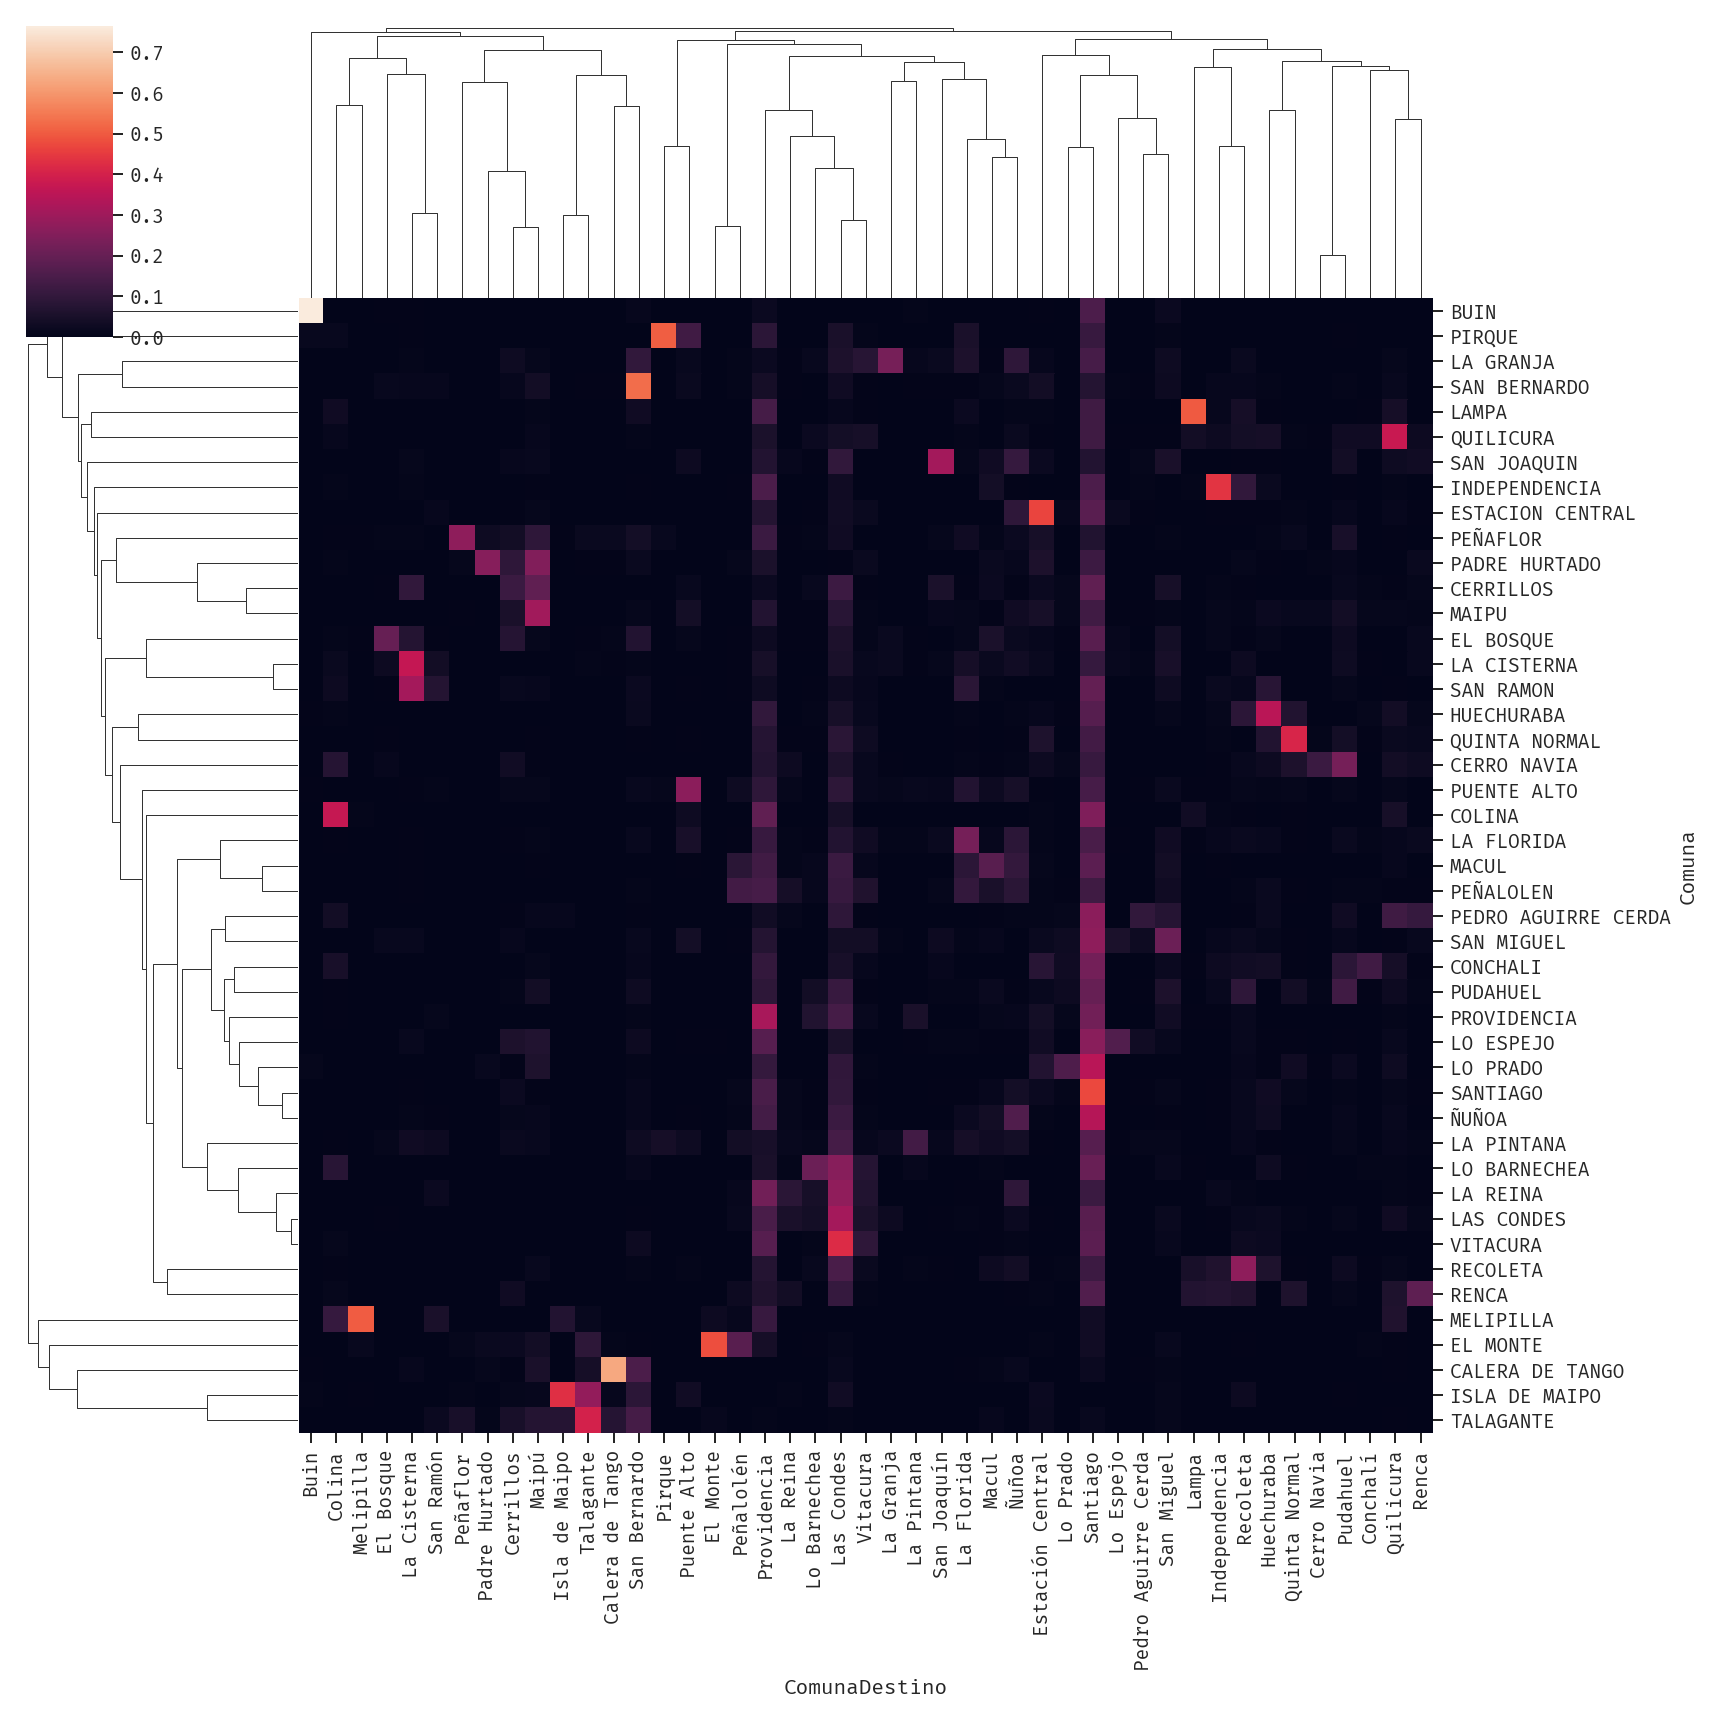

In [44]:
sns.clustermap(comuna_od.loc['Al trabajo'], metric='correlation', figsize=(12,12))

Esperábamos ver la concentración de viajes en Santiago, Providencia y Las Condes --- es un hecho conocido y corroborado en este gráfico. Sin embargo, existen otras agrupaciones interesantes. Primero, el gráfico hizo la separación entre las comunas urbanas y las rurales. También agrupó otros polos de trabajo, como el grupo de comunas que incluye a Padre Hurtado, Peñaflor y Maipú. Maipú es una de las comunas más pobladas del país y tiene su propio centro (la Plaza de Maipú).